In [2]:
import os
from skimage import io
from skimage import color
import cv2
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import json
from PIL import Image
from pathlib import Path
import matplotlib.patches as mpatches
from aicspylibczi import CziFile
import glob
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import czifile
import tifffile as tiff
from tifffile import imread, imsave
from aicsimageio import AICSImage

In [3]:
name = 'NCC001Post_NCC011Post'

visium_spots_path = '/Users/serenapei/ASTAR/Y90HCC/' + name + '/outs/spatial/spots_class/Visium_spots_class.csv'
visium_spots = pd.read_csv(visium_spots_path)
visium_spots

tissue_positions_path = '/Users/serenapei/ASTAR/Y90HCC/' +  name + '/outs/spatial/tissue_positions.csv'
tissue_positions = pd.read_csv(tissue_positions_path)
tissue_positions

barcode  in_tissue  array_row  array_col  pxl_row_in_fullres  \
0     ACGCCTGACACGCGCT-1          0          0          0                3214   
1     TACCGATCCAACACTT-1          0          1          1                3191   
2     ATTAAAGCGGACGAGC-1          0          0          2                3169   
3     GATAAGGGACGATTAG-1          0          1          3                3146   
4     GTGCAAATCACCAATA-1          0          0          4                3124   
...                  ...        ...        ...        ...                 ...   
4987  GAACGTTTGTATCCAC-1          0         77        123                 380   
4988  ATTGAATTCCCTGTAG-1          0         76        124                 358   
4989  TACCTCACCAATTGTA-1          0         77        125                 334   
4990  AGTCGAATTAGCGTAA-1          0         76        126                 312   
4991  TTGAAGTGCATCTACA-1          0         77        127                 289   

      pxl_col_in_fullres  
0                    311  
1                    350  
2                    310  
3                    349  
4                    309  
...                  ...  
4987                3292  
4988                3252  
4989                3291  
4990                3251  
4991                3290  

[4992 rows x 6 columns]

In [10]:
label_map = {0: "not in tissue", 1: "tumor epithelium", 2: "stroma fibrosis", 3: "necrosis", 4: "nonneoplastic", 
             5: "uncertain favor nonneoplastic", 6: " uncertain", 7: "uncertain favor neoplastic", 8: "none"}

sample_ids = []
spot_barcodes = []
tissue_categories = []

for i in range(len(visium_spots)):
    row = visium_spots.iloc[i]
    # 0 for not in tissue, 1 for in tissue
    intissue = tissue_positions.iloc[i]['in_tissue']
    sample_ids.append(name)
    spot_barcodes.append(row['barcode'])
    # 0 means background
    # background and not in tissue
    if row['Class'] == 0 and intissue == 0:
        tissue_categories.append(label_map[0])
    # no annotation -> None
    elif row['Class'] == 0 and intissue == 1:
        tissue_categories.append(label_map[8])
    else:
        tissue_categories.append(label_map[row['Class']])

data = {'sample id': sample_ids,
        'spot barcode': spot_barcodes,
        'tissue category': tissue_categories}

df = pd.DataFrame(data)

save_path = '/Users/serenapei/ASTAR/Y90HCC/' + name + '/outs/spatial/spots_class/spots_tissue.csv'
df.to_csv(save_path, index=False)
df


sample id        spot barcode tissue category
0     NCC001Post_NCC011Post  ACGCCTGACACGCGCT-1   not in tissue
1     NCC001Post_NCC011Post  TACCGATCCAACACTT-1   not in tissue
2     NCC001Post_NCC011Post  ATTAAAGCGGACGAGC-1   not in tissue
3     NCC001Post_NCC011Post  GATAAGGGACGATTAG-1   not in tissue
4     NCC001Post_NCC011Post  GTGCAAATCACCAATA-1   not in tissue
...                     ...                 ...             ...
4987  NCC001Post_NCC011Post  GAACGTTTGTATCCAC-1   not in tissue
4988  NCC001Post_NCC011Post  ATTGAATTCCCTGTAG-1   not in tissue
4989  NCC001Post_NCC011Post  TACCTCACCAATTGTA-1   not in tissue
4990  NCC001Post_NCC011Post  AGTCGAATTAGCGTAA-1   not in tissue
4991  NCC001Post_NCC011Post  TTGAAGTGCATCTACA-1   not in tissue

[4992 rows x 3 columns]

In [8]:
# count number of rows that correspond to spots that are in tissue
count = 0
for i in range(len(visium_spots)):
    if df.iloc[i]['tissue category'] != "not in tissue":
        count += 1
count

770

In [4]:
# pipeline
# RUN THIS CELL ONLY
label_map = {0: "not in tissue", 1: "tumor epithelium", 2: "stroma fibrosis", 3: "necrosis", 4: "nonneoplastic", 
             5: "uncertain favor nonneoplastic", 6: " uncertain", 7: "uncertain favor neoplastic", 8: "none"}

file_map = {'NCC001Post_NCC011Post': ['HCC Y90 GEX 20211122 Frame A.czi_Tumor_(4.00,400,1360,34816,31616)-mask.png','HCC Y90 GEX 20211122 Frame A.czi_Stroma_(4.00,2976,2672,32000,30656)-mask.png'],
            'NCC012Post_NCC018Post': ['HCC Y90 GEX 20211122 Frame B.czi_Tumor_(4.00,2960,2760,24672,23656)-mask.png', 'HCC Y90 GEX 20211122 Frame B.czi_Stroma_(4.00,3088,11360,24528,14952)-mask.png'],
            'NCC015Post_NCC017Post': ['HCC Y90 GEX 20211122 Frame C.czi_Tumor_(4.00,5544,11944,23896,14616)-mask.png','HCC Y90 GEX 20211122 Frame C.czi_Stroma_(4.00,5400,2584,31264,24360)-mask.png'],
            'NCC039Post_NCC034Post': ['HCC Y90 GEX 20211122 Frame D.czi_Tumor_(4.00,328,144,34728,34720)-mask.png','HCC Y90 GEX 20211122 Frame D.czi_Stroma_(4.00,2576,1424,32360,25864)-mask.png'],
            'NCC027Post': ['HCC Y90 GEX 20221206 Frame A.czi_Tumor_(4.00,0,24,30008,35368)-mask.png','HCC Y90 GEX 20221206 Frame A.czi_Stroma_(4.00,0,0,35640,35256)-mask.png'],
            'NCC040Post': ['HCC Y90 GEX 20221206 Frame B.czi_Tumor_(4.00,960,720,34872,33784)-mask.png','HCC Y90 GEX 20221206 Frame B.czi_Stroma_(4.00,960,664,34872,33864)-mask.png'],
            'NCC037Post_NCC023Post': ['HCC Y90 GEX 20221206 Frame C.czi_Tumor_(4.00,232,976,35576,33912)-mask.png','HCC Y90 GEX 20221206 Frame C.czi_Stroma_(4.00,1144,648,34200,33888)-mask.png'],
            'NCC037Pre_NCC040A1Pre': ['HCC Y90 GEX 20221214 Frame A.czi_Tumor_(4.00,1547,3452,23802,17219)-mask.png','HCC Y90 GEX 20221214 Frame A.czi_Stroma_(4.00,1565,3470,23556,21574)-mask.png'],
            'NCC023Pre_NCC034Pre': ['HCC Y90 GEX 20221214 Frame B.czi_Tumor_(4.00,0,0,26387,22060)-mask.png','HCC Y90 GEX 20221214 Frame B.czi_Stroma_(4.00,1365,17,20361,22008)-mask.png','HCC Y90 GEX 20221214 Frame B.czi_Epithelium_(4.00,0,0,26404,22072)-mask.png'],
            'NCC027Pre_NCC040A2Pre': ['HCC Y90 GEX 20221214 Frame C.czi_Tumor_(4.00,4461,2110,18907,22037)-mask.png','HCC Y90 GEX 20221214 Frame C.czi_Stroma_(4.00,4472,375,21159,24277)-mask.png','HCC Y90 GEX 20221214 Frame C.czi_Epithelium_(4.00,4478,2122,18831,22025)-mask.png'],
            'NCC015Post_NCC012Post': ['V11N0-086_H&E_Frame B.czi_Tumor_(4.00,5504,2704,40920,41664)-mask.png','V11N0-086_H&E_Frame B.czi_Stroma_(4.00,1112,176,45360,44432)-mask.png'],
            'NCC015Pre_NCC012Pre': ['V11N0-086_H&E_Whole Slide.czi - Scene #1_Tumor_(4.00,456,104,42536,45856)-mask.png','V11N0-086_H&E_Whole Slide.czi - Scene #1_Stroma_(4.00,640,0,45840,46056)-mask.png'],
            'NCC016Pre_NCC011Pre': ['V11N0-086_H&E_Whole Slide.czi - Scene #3_Tumor_(4.00,1040,336,42456,43112)-mask.png','V11N0-086_H&E_Whole Slide.czi - Scene #3_Stroma_(4.00,1064,352,46432,44448)-mask.png'],
            'NCC016Post_NCC011Post': ['V11N0-086_H&E_Whole Slide.czi - Scene #4_Tumor_(4.00,1360,560,44960,45352)-mask.png','V11N0-086_H&E_Whole Slide.czi - Scene #4_Stroma_(4.00,0,2352,46480,44480)-mask.png']}

all_dataframes = []
samples = file_map.keys()
for name in samples:
    visium_spots_path = '/Users/serenapei/ASTAR/Y90HCC/' + name + '/outs/spatial/spots_class/Visium_spots_class.csv'
    visium_spots = pd.read_csv(visium_spots_path)

    tissue_positions_path = '/Users/serenapei/ASTAR/Y90HCC/' +  name + '/outs/spatial/tissue_positions.csv'
    tissue_positions = pd.read_csv(tissue_positions_path)

    sample_ids = []
    spot_barcodes = []
    tissue_categories = []

    for i in range(len(visium_spots)):
        row = visium_spots.iloc[i]
        # 0 for not in tissue, 1 for in tissue
        intissue = tissue_positions.iloc[i]['in_tissue']
        sample_ids.append(name)
        spot_barcodes.append(row['barcode'])
        # 0 means background
        # background and not in tissue
        if row['Class'] == 0 and intissue == 0:
            tissue_categories.append(label_map[0])
        # no annotation -> None
        elif row['Class'] == 0 and intissue == 1:
            tissue_categories.append(label_map[8])
        else:
            tissue_categories.append(label_map[row['Class']])

        data = {'sample id': sample_ids,
                'spot barcode': spot_barcodes,
                'tissue category': tissue_categories}

        df = pd.DataFrame(data)

        save_path = '/Users/serenapei/ASTAR/Y90HCC/' + name + '/outs/spatial/spots_class/spots_tissue.csv'
        df.to_csv(save_path, index=False)

    
        all_dataframes.append(df)

all_dataframes = pd.concat(all_dataframes, ignore_index=True)

# save as csv
save_path = '/Users/serenapei/ASTAR/HE2Visium/spots_tissue.csv'
all_dataframes.to_csv(save_path, index=False)
print('saved csv')
    

saved csv


In [76]:
import os
from skimage import io
from skimage import color
import cv2
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import json
from PIL import Image
from pathlib import Path
Image.MAX_IMAGE_PIXELS = None
Visium_HE_downscale=10



In [77]:
# visium_dir = "/data_c2/data_n3/home/maichan/Projects/Y90/Visium/spaceranger_out_rerun"
visium_dir = "/Users/serenapei/ASTAR/Y90HCC"
# mask_dir = "/data_c2/data_n3/home/maichan/Projects/Y90/Visium/QuPath_masks/masks"
mask_dir = "/Users/serenapei/ASTAR/Y90HCC/QuPath_masks"
# mapping_file = "/data_c2/data_n3/home/maichan/Projects/Y90/Visium/code/HE2Visium_mapping/file_mapping_FF_FFPE.csv"
mapping_file = '/Users/serenapei/ASTAR/HE2Visium/Copy of file_mapping_FF_FFPE - file_mapping_FF_FFPE.csv'
space_folders = list(pd.read_csv(mapping_file)["space_folders"])
path0 = list(pd.read_csv(mapping_file)["Tumor_mask"])
path1 = list(pd.read_csv(mapping_file)["TumorEpithelium_mask"])
path2 = list(pd.read_csv(mapping_file)["StromaFibrosis_mask"])
path3 = list(pd.read_csv(mapping_file)["Necrosis_mask"])
path4 = list(pd.read_csv(mapping_file)["OutOfFocus_mask"])
path5 = list(pd.read_csv(mapping_file)["Uncertain_mask"])
path6 = list(pd.read_csv(mapping_file)["UncertainFavorNonneoplastic_mask"])
path7 = list(pd.read_csv(mapping_file)["UncertainFavorNeoplastic_mask"])
path8 = list(pd.read_csv(mapping_file)["NonNeoplastic_mask"])
path9 = list(pd.read_csv(mapping_file)["None_mask"])

downsample = 4
VISIUM_SPOT_DIAMETER = 55
visium_spots_log = os.path.join(os.path.join(visium_dir,"spots_class", f"log.txt"))


def is_nan(value):
    if isinstance(value, (float, np.float64, np.float32)):
        return np.isnan(value)
    elif isinstance(value, str):
        return value.lower() == "na"
    return False

print(mapping_file)
print(space_folders)
#print(epithelial_path)


#space_folders = space_folders[0]
for i, space in enumerate(space_folders):
    #i=0;space = 'NCC001Post_NCC011Post'
    #i=9;space = 'NCC027Pre_NCC040A2Pre'

    os.makedirs(os.path.join(visium_dir, f"spots_class"),exist_ok=True)
    visium_spots_csv_save = os.path.join(os.path.join(visium_dir,"spots_class", f"{space}_spots_class.csv"))
        # Set the visium path to get info from based on the mapping_file
        
    #visium_path = Path(os.path.join(visium_dir, space))
    visium_path = Path(os.path.join(visium_dir, space, "outs/spatial"))
    print(visium_path)
    for path in visium_path.rglob(pattern='*.json'):
        print(path)
    with open(list(visium_path.rglob('scalefactors_json.json'))[0]) as f:
        scale_factors = json.load(f)   
    print(scale_factors)
    #print(epithelial_path[i])

/Users/serenapei/ASTAR/HE2Visium/Copy of file_mapping_FF_FFPE - file_mapping_FF_FFPE.csv
['NCC001Post_NCC011Post', 'NCC012Post_NCC018Post', 'NCC015Post_NCC017Post', 'NCC039Post_NCC034Post', 'NCC027Post', 'NCC040Post', 'NCC037Post_NCC023Post', 'NCC037Pre_NCC040A1Pre', 'NCC023Pre_NCC034Pre', 'NCC027Pre_NCC040A2Pre', 'NCC015Post_NCC012Post', 'NCC015Pre_NCC012Pre', 'NCC016Pre_NCC011Pre', 'NCC016Post_NCC011Post']
/Users/serenapei/ASTAR/Y90HCC/NCC001Post_NCC011Post/outs/spatial
/Users/serenapei/ASTAR/Y90HCC/NCC001Post_NCC011Post/outs/spatial/scalefactors_json.json
{'tissue_hires_scalef': 0.5546312, 'tissue_lowres_scalef': 0.16638935, 'fiducial_diameter_fullres': 47.49106630775637, 'spot_diameter_fullres': 29.399231523849178}
/Users/serenapei/ASTAR/Y90HCC/NCC012Post_NCC018Post/outs/spatial
/Users/serenapei/ASTAR/Y90HCC/NCC012Post_NCC018Post/outs/spatial/scalefactors_json.json
{'tissue_hires_scalef': 0.53835803, 'tissue_lowres_scalef': 0.1615074, 'fiducial_diameter_fullres': 47.7833919779459, 

In [78]:
#scaling factors
#print(scale_factors)
tissue_hires_scalef = scale_factors['tissue_hires_scalef']
scale = tissue_hires_scalef/Visium_HE_downscale
scale_factor = scale* downsample
spot_diameter_fullres = scale_factors['spot_diameter_fullres']
print('tissue_hires_scalef=',tissue_hires_scalef)
print('scale=',scale)
print('scale_factor=',scale_factor)
print('spot_diameter_fullres',spot_diameter_fullres)

tissue_hires_scalef= 0.42680323
scale= 0.042680323
scale_factor= 0.170721292
spot_diameter_fullres 37.81715885763289


In [79]:
myimg = Image.open(os.path.join(visium_path,'aligned_fiducials.jpg'))
myimg = np.asarray(myimg)
high_res_x = myimg.shape[1]
high_res_y = myimg.shape[0]    
print(high_res_x,high_res_y)

1986 2000


In [80]:
def padding(image, size, mask_coords):
        '''This function exists to add padding to the mask in the appropriate position based on the anchor points'''
        height, width = image.size
        print('height, width=',height, width)
        #set position of anchor points 
        print('mask_coords',mask_coords)
        right = size[0] - mask_coords[2]
        left = mask_coords[0]
        top = mask_coords[1]
        bottom = size[-1] - mask_coords[-1]
        new_width = width + right + left
        new_height = height + top + bottom
        print(width, height, left, right, top, bottom)
        # create an image that is the required size
        result = Image.new(image.mode, size)
        print(result.size) 
        #paste image in position based on anchor poinr
        result.paste(image, (left, top))
        return result

In [81]:
def sum_pixels_around_points(image, points, radius):
        #mapping = {0:3,1:4,2:5}
        #mapping = {0:3, 1:1, 2:2}
        mapping = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8}
        height, width = image.shape
        print(image.shape)
        y_coords, x_coords = np.indices((height, width))
        print(y_coords, x_coords)
        total_sum = []
        image_masked = np.zeros_like(image)
        for i, point in enumerate(points):
            print(point[1:])
            x, y = point[1:]
            mask = ((x_coords - x) ** 2 + (y_coords - y) ** 2) <= radius ** 2
            counts = np.unique(image[mask],return_counts = True)
            conversion = counts[0][np.argmax(counts[1])]
            image_masked[mask] = int(mapping[conversion])
        # for i, point in enumerate(points):
        #     x, y = point[1], point[2]
        #     mask = ((x_coords - x) ** 2 + (y_coords - y) ** 2) <= radius ** 2
        #     counts = np.unique(image[mask],return_counts = True)
            #0 is background, 1 is tumor, 2 is stroma 
            
            # Mask values other than 0
            values_mask = counts[0] != 0
            # Check if any values are masked (i.e., 1, 2, or 3 exists)
            if np.any(values_mask):
                # Filter the counts based on the mask
                filtered_counts = counts[1][values_mask]
                
                # Get the index of the maximum count in the filtered counts
                max_index_filtered = np.argmax(filtered_counts)
                
                # Use this index to get the corresponding value from the masked values in counts[0]
                conversion = counts[0][values_mask][max_index_filtered]
            else:
                # If no 1, 2, or 3 values are detected, default to the most frequent value
                conversion = counts[0][np.argmax(counts[1])]

            
            # try:
                # conversion = counts[0][np.argmax(counts[1])]
            # except:
                # return(None, None) 
            image_masked[mask] = int(mapping[conversion])
            points[i] = point+ (conversion,)
        return image_masked, points

10
/Users/serenapei/ASTAR/Y90HCC/QuPath_masks/HCC Y90 GEX 20211122 Frame A.czi_Tumor_(4.00,17506,21845,5331,7263)-mask.png
/Users/serenapei/ASTAR/Y90HCC/QuPath_masks/HCC Y90 GEX 20211122 Frame A.czi_tumor_epithelium_(4.00,17547,5132,4315,3652)-mask.png
/Users/serenapei/ASTAR/Y90HCC/QuPath_masks/HCC Y90 GEX 20211122 Frame A.czi_tumor_epithelium_(4.00,20031,27166,3296,2438)-mask.png
/Users/serenapei/ASTAR/Y90HCC/QuPath_masks/HCC Y90 GEX 20211122 Frame A.czi_tumor_epithelium_(4.00,21652,16613,6527,3919)-mask.png
/Users/serenapei/ASTAR/Y90HCC/QuPath_masks/HCC Y90 GEX 20211122 Frame A.czi_stroma_fibrosis_(4.00,17315,4779,4776,4656)-mask.png
/Users/serenapei/ASTAR/Y90HCC/QuPath_masks/HCC Y90 GEX 20211122 Frame A.czi_stroma_fibrosis_(4.00,17500,21310,7271,7836)-mask.png
/Users/serenapei/ASTAR/Y90HCC/QuPath_masks/HCC Y90 GEX 20211122 Frame A.czi_stroma_fibrosis_(4.00,19432,24611,6778,8287)-mask.png
/Users/serenapei/ASTAR/Y90HCC/QuPath_masks/HCC Y90 GEX 20211122 Frame A.czi_stroma_fibrosis_(4.0

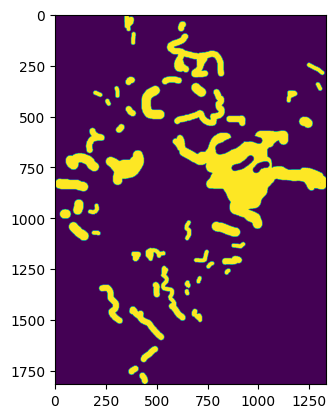

height, width= 227 310
mask_coords [747, 932, 227, 309]
310 227 747 1759 932 1691
(1986, 2000)


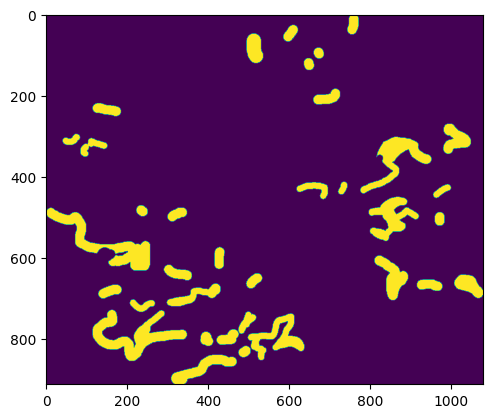

height, width= 184 155
mask_coords [748, 219, 184, 155]
155 184 748 1802 219 1845
(1986, 2000)
height, width= 184 155
mask_coords [854, 1159, 140, 104]
155 184 854 1846 1159 1896
(1986, 2000)
height, width= 184 155
mask_coords [924, 709, 278, 167]
155 184 924 1708 709 1833
(1986, 2000)


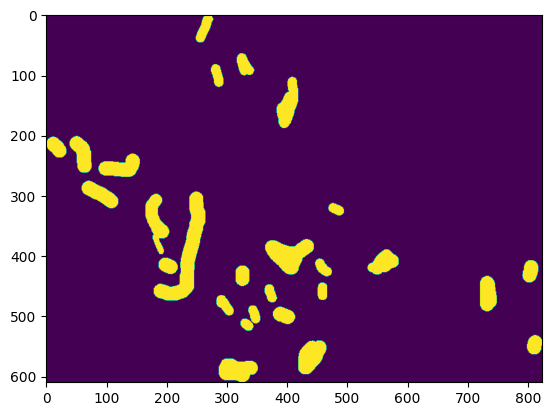

height, width= 140 104
mask_coords [748, 219, 184, 155]
104 140 748 1802 219 1845
(1986, 2000)
height, width= 140 104
mask_coords [854, 1159, 140, 104]
104 140 854 1846 1159 1896
(1986, 2000)
height, width= 140 104
mask_coords [924, 709, 278, 167]
104 140 924 1708 709 1833
(1986, 2000)


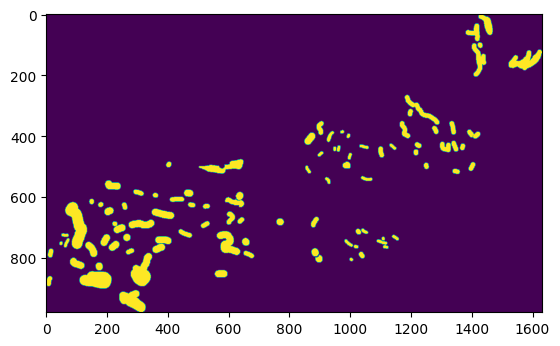

height, width= 278 167
mask_coords [748, 219, 184, 155]
167 278 748 1802 219 1845
(1986, 2000)
height, width= 278 167
mask_coords [854, 1159, 140, 104]
167 278 854 1846 1159 1896
(1986, 2000)
height, width= 278 167
mask_coords [924, 709, 278, 167]
167 278 924 1708 709 1833
(1986, 2000)


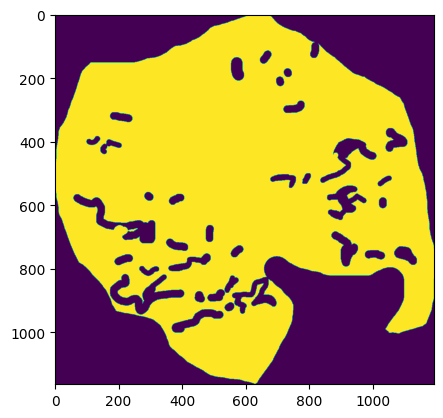

height, width= 203 198
mask_coords [739, 203, 203, 198]
198 203 739 1783 203 1802
(1986, 2000)
height, width= 203 198
mask_coords [746, 909, 310, 334]
198 203 746 1676 909 1666
(1986, 2000)
height, width= 203 198
mask_coords [829, 1050, 289, 353]
198 203 829 1697 1050 1647
(1986, 2000)
height, width= 203 198
mask_coords [878, 1133, 57, 135]
198 203 878 1929 1133 1865
(1986, 2000)
height, width= 203 198
mask_coords [912, 703, 310, 179]
198 203 912 1676 703 1821
(1986, 2000)
height, width= 203 198
mask_coords [917, 526, 56, 55]
198 203 917 1930 526 1945
(1986, 2000)


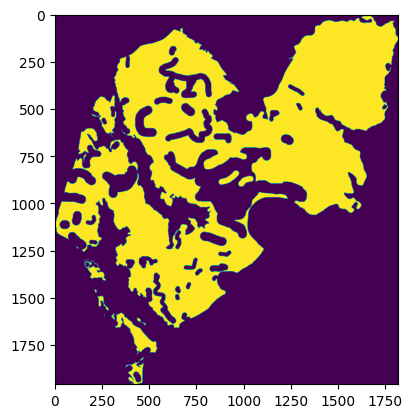

height, width= 310 334
mask_coords [739, 203, 203, 198]
334 310 739 1783 203 1802
(1986, 2000)
height, width= 310 334
mask_coords [746, 909, 310, 334]
334 310 746 1676 909 1666
(1986, 2000)
height, width= 310 334
mask_coords [829, 1050, 289, 353]
334 310 829 1697 1050 1647
(1986, 2000)
height, width= 310 334
mask_coords [878, 1133, 57, 135]
334 310 878 1929 1133 1865
(1986, 2000)
height, width= 310 334
mask_coords [912, 703, 310, 179]
334 310 912 1676 703 1821
(1986, 2000)
height, width= 310 334
mask_coords [917, 526, 56, 55]
334 310 917 1930 526 1945
(1986, 2000)


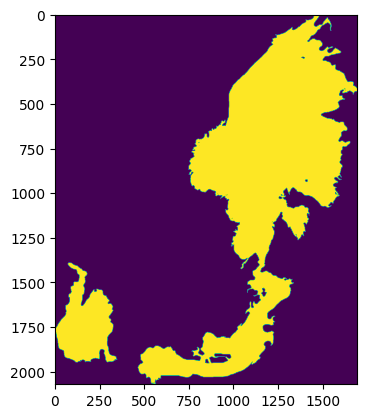

height, width= 289 353
mask_coords [739, 203, 203, 198]
353 289 739 1783 203 1802
(1986, 2000)
height, width= 289 353
mask_coords [746, 909, 310, 334]
353 289 746 1676 909 1666
(1986, 2000)
height, width= 289 353
mask_coords [829, 1050, 289, 353]
353 289 829 1697 1050 1647
(1986, 2000)
height, width= 289 353
mask_coords [878, 1133, 57, 135]
353 289 878 1929 1133 1865
(1986, 2000)
height, width= 289 353
mask_coords [912, 703, 310, 179]
353 289 912 1676 703 1821
(1986, 2000)
height, width= 289 353
mask_coords [917, 526, 56, 55]
353 289 917 1930 526 1945
(1986, 2000)


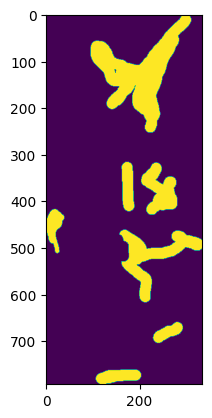

height, width= 57 135
mask_coords [739, 203, 203, 198]
135 57 739 1783 203 1802
(1986, 2000)
height, width= 57 135
mask_coords [746, 909, 310, 334]
135 57 746 1676 909 1666
(1986, 2000)
height, width= 57 135
mask_coords [829, 1050, 289, 353]
135 57 829 1697 1050 1647
(1986, 2000)
height, width= 57 135
mask_coords [878, 1133, 57, 135]
135 57 878 1929 1133 1865
(1986, 2000)
height, width= 57 135
mask_coords [912, 703, 310, 179]
135 57 912 1676 703 1821
(1986, 2000)
height, width= 57 135
mask_coords [917, 526, 56, 55]
135 57 917 1930 526 1945
(1986, 2000)


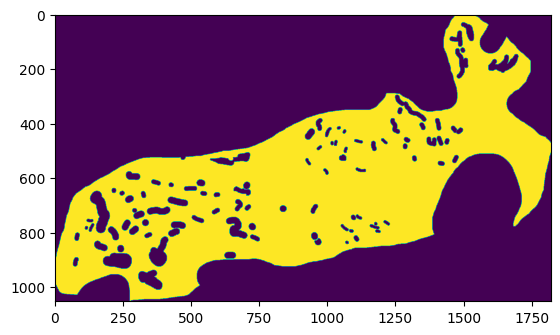

height, width= 310 179
mask_coords [739, 203, 203, 198]
179 310 739 1783 203 1802
(1986, 2000)
height, width= 310 179
mask_coords [746, 909, 310, 334]
179 310 746 1676 909 1666
(1986, 2000)
height, width= 310 179
mask_coords [829, 1050, 289, 353]
179 310 829 1697 1050 1647
(1986, 2000)
height, width= 310 179
mask_coords [878, 1133, 57, 135]
179 310 878 1929 1133 1865
(1986, 2000)
height, width= 310 179
mask_coords [912, 703, 310, 179]
179 310 912 1676 703 1821
(1986, 2000)
height, width= 310 179
mask_coords [917, 526, 56, 55]
179 310 917 1930 526 1945
(1986, 2000)


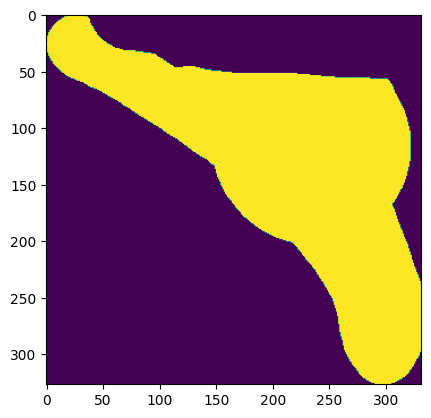

height, width= 56 55
mask_coords [739, 203, 203, 198]
55 56 739 1783 203 1802
(1986, 2000)
height, width= 56 55
mask_coords [746, 909, 310, 334]
55 56 746 1676 909 1666
(1986, 2000)
height, width= 56 55
mask_coords [829, 1050, 289, 353]
55 56 829 1697 1050 1647
(1986, 2000)
height, width= 56 55
mask_coords [878, 1133, 57, 135]
55 56 878 1929 1133 1865
(1986, 2000)
height, width= 56 55
mask_coords [912, 703, 310, 179]
55 56 912 1676 703 1821
(1986, 2000)
height, width= 56 55
mask_coords [917, 526, 56, 55]
55 56 917 1930 526 1945
(1986, 2000)


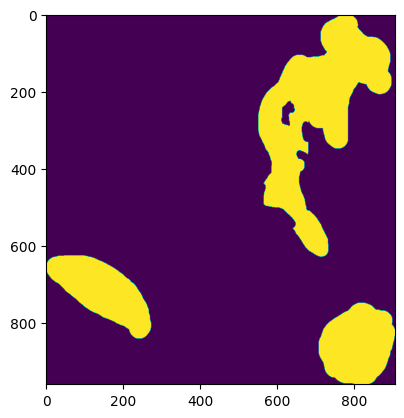

height, width= 154 163
mask_coords [829, 1116, 154, 163]
163 154 829 1832 1116 1837
(1986, 2000)
height, width= 154 163
mask_coords [844, 421, 169, 117]
163 154 844 1817 421 1883
(1986, 2000)


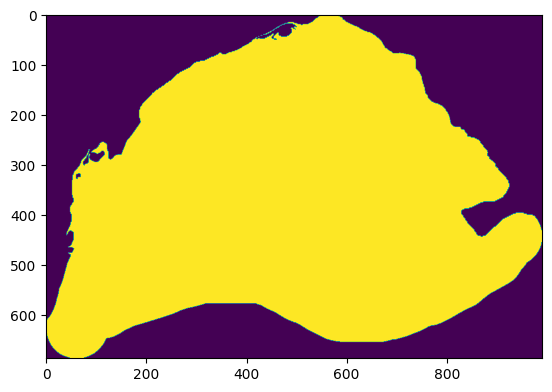

height, width= 169 117
mask_coords [829, 1116, 154, 163]
117 169 829 1832 1116 1837
(1986, 2000)
height, width= 169 117
mask_coords [844, 421, 169, 117]
117 169 844 1817 421 1883
(1986, 2000)


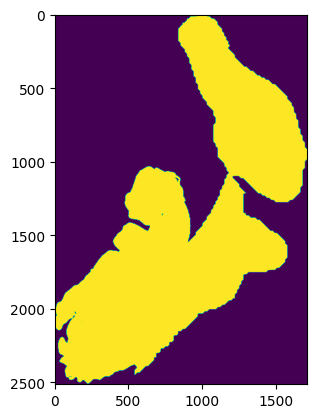

height, width= 292 429
mask_coords [146, 628, 292, 428]
429 292 146 1694 628 1572
(1986, 2000)
height, width= 292 429
mask_coords [976, 508, 63, 103]
429 292 976 1923 508 1897
(1986, 2000)


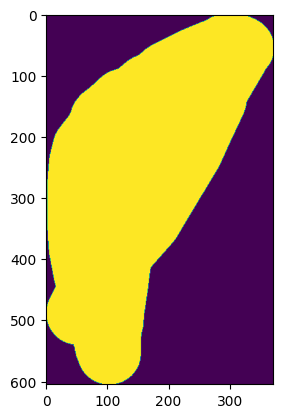

height, width= 63 103
mask_coords [146, 628, 292, 428]
103 63 146 1694 628 1572
(1986, 2000)
height, width= 63 103
mask_coords [976, 508, 63, 103]
103 63 976 1923 508 1897
(1986, 2000)


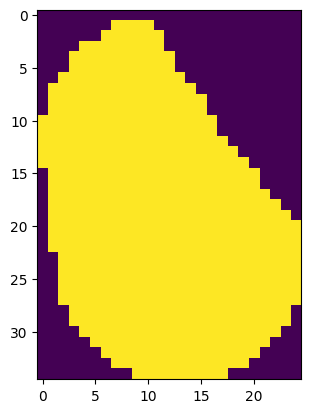

height, width= 4 5
mask_coords [904, 1216, 4, 5]
5 4 904 1982 1216 1995
(1986, 2000)
(2000, 1986)
[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1997 1997 1997 ... 1997 1997 1997]
 [1998 1998 1998 ... 1998 1998 1998]
 [1999 1999 1999 ... 1999 1999 1999]] [[   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 ...
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]]
(202.30473102, 1816.9013501099998)
(224.07169574999998, 1804.5240564399999)
(202.30473102, 1792.14676277)
(223.64489251999998, 1779.7694691)
(202.30473102, 1767.39217543)
(223.64489251999998, 1754.5880785299998)
(202.30473102, 1742.2107848599999)
(223.64489251999998, 1729.83349119)
(202.30473102, 1717.45619752)
(223.64489251999998, 1705.07890385)
(202.30473102, 1692.70161018)
(223.64489251999998, 1680.32431651)
(201.87792779, 1667.94702283999

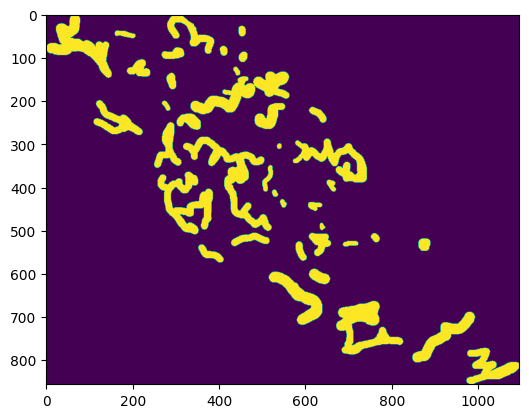

height, width= 187 146
mask_coords [741, 887, 187, 146]
146 187 741 1799 887 1854
(1986, 2000)


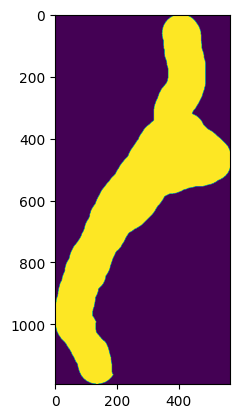

height, width= 96 203
mask_coords [132, 640, 96, 203]
203 96 132 1890 640 1797
(1986, 2000)
height, width= 96 203
mask_coords [286, 549, 267, 583]
203 96 286 1719 549 1417
(1986, 2000)
height, width= 96 203
mask_coords [735, 842, 186, 107]
203 96 735 1800 842 1893
(1986, 2000)
height, width= 96 203
mask_coords [743, 892, 189, 142]
203 96 743 1797 892 1858
(1986, 2000)


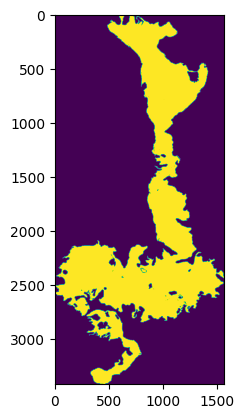

height, width= 267 583
mask_coords [132, 640, 96, 203]
583 267 132 1890 640 1797
(1986, 2000)
height, width= 267 583
mask_coords [286, 549, 267, 583]
583 267 286 1719 549 1417
(1986, 2000)
height, width= 267 583
mask_coords [735, 842, 186, 107]
583 267 735 1800 842 1893
(1986, 2000)
height, width= 267 583
mask_coords [743, 892, 189, 142]
583 267 743 1797 892 1858
(1986, 2000)


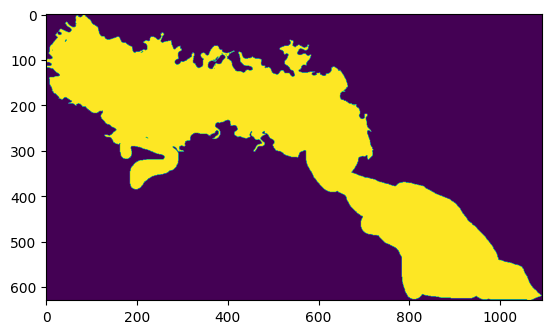

height, width= 186 107
mask_coords [132, 640, 96, 203]
107 186 132 1890 640 1797
(1986, 2000)
height, width= 186 107
mask_coords [286, 549, 267, 583]
107 186 286 1719 549 1417
(1986, 2000)
height, width= 186 107
mask_coords [735, 842, 186, 107]
107 186 735 1800 842 1893
(1986, 2000)
height, width= 186 107
mask_coords [743, 892, 189, 142]
107 186 743 1797 892 1858
(1986, 2000)


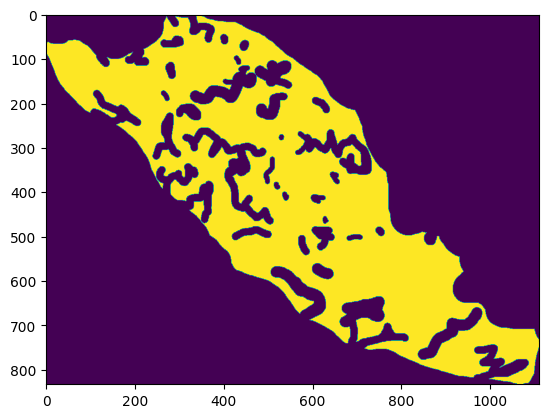

height, width= 189 142
mask_coords [132, 640, 96, 203]
142 189 132 1890 640 1797
(1986, 2000)
height, width= 189 142
mask_coords [286, 549, 267, 583]
142 189 286 1719 549 1417
(1986, 2000)
height, width= 189 142
mask_coords [735, 842, 186, 107]
142 189 735 1800 842 1893
(1986, 2000)
height, width= 189 142
mask_coords [743, 892, 189, 142]
142 189 743 1797 892 1858
(1986, 2000)


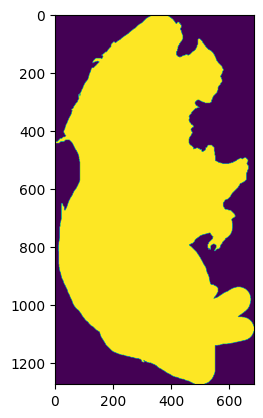

height, width= 116 217
mask_coords [151, 742, 116, 217]
217 116 151 1870 742 1783
(1986, 2000)
height, width= 116 217
mask_coords [483, 918, 110, 139]
217 116 483 1876 918 1861
(1986, 2000)
height, width= 116 217
mask_coords [493, 643, 114, 238]
217 116 493 1872 643 1762
(1986, 2000)


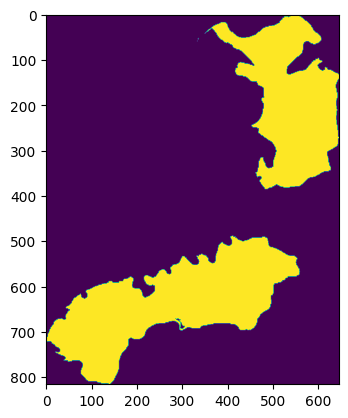

height, width= 110 139
mask_coords [151, 742, 116, 217]
139 110 151 1870 742 1783
(1986, 2000)
height, width= 110 139
mask_coords [483, 918, 110, 139]
139 110 483 1876 918 1861
(1986, 2000)
height, width= 110 139
mask_coords [493, 643, 114, 238]
139 110 493 1872 643 1762
(1986, 2000)


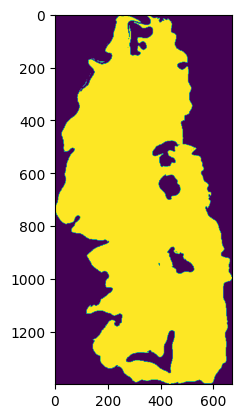

height, width= 114 238
mask_coords [151, 742, 116, 217]
238 114 151 1870 742 1783
(1986, 2000)
height, width= 114 238
mask_coords [483, 918, 110, 139]
238 114 483 1876 918 1861
(1986, 2000)
height, width= 114 238
mask_coords [493, 643, 114, 238]
238 114 493 1872 643 1762
(1986, 2000)


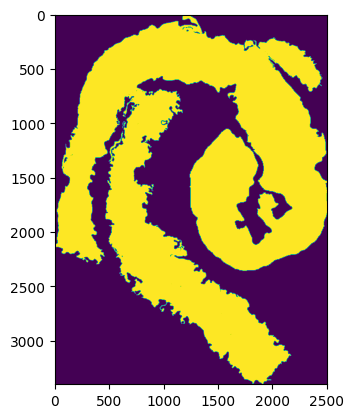

height, width= 427 580
mask_coords [746, 465, 427, 580]
580 427 746 1559 465 1420
(1986, 2000)
(2000, 1986)
[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1997 1997 1997 ... 1997 1997 1997]
 [1998 1998 1998 ... 1998 1998 1998]
 [1999 1999 1999 ... 1999 1999 1999]] [[   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 ...
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]]
(202.30473102, 1816.9013501099998)
(224.07169574999998, 1804.5240564399999)
(202.30473102, 1792.14676277)
(223.64489251999998, 1779.7694691)
(202.30473102, 1767.39217543)
(223.64489251999998, 1754.5880785299998)
(202.30473102, 1742.2107848599999)
(223.64489251999998, 1729.83349119)
(202.30473102, 1717.45619752)
(223.64489251999998, 1705.07890385)
(202.30473102, 1692.70161018)
(223.64489251999998, 1680.32431651)
(201.87792779, 1667.9

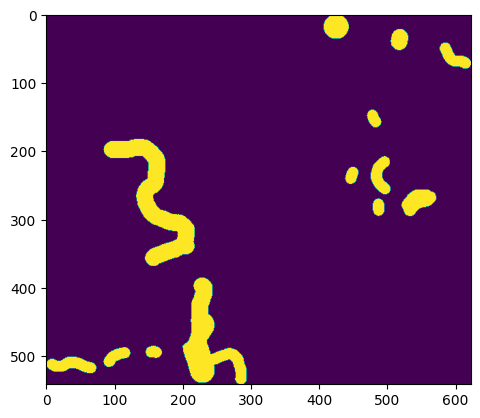

height, width= 106 92
mask_coords [681, 614, 106, 92]
92 106 681 1880 614 1908
(1986, 2000)


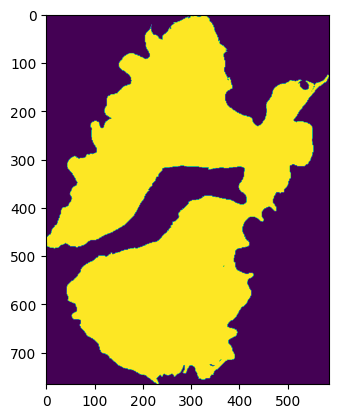

height, width= 100 130
mask_coords [265, 595, 100, 130]
130 100 265 1886 595 1870
(1986, 2000)
height, width= 100 130
mask_coords [660, 613, 123, 108]
130 100 660 1863 613 1892
(1986, 2000)
height, width= 100 130
mask_coords [754, 585, 197, 348]
130 100 754 1789 585 1652
(1986, 2000)
height, width= 100 130
mask_coords [1117, 893, 27, 33]
130 100 1117 1959 893 1967
(1986, 2000)


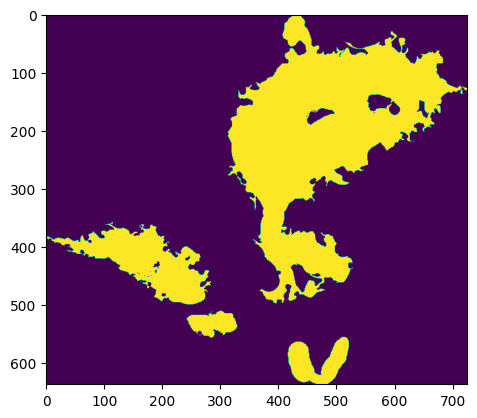

height, width= 123 108
mask_coords [265, 595, 100, 130]
108 123 265 1886 595 1870
(1986, 2000)
height, width= 123 108
mask_coords [660, 613, 123, 108]
108 123 660 1863 613 1892
(1986, 2000)
height, width= 123 108
mask_coords [754, 585, 197, 348]
108 123 754 1789 585 1652
(1986, 2000)
height, width= 123 108
mask_coords [1117, 893, 27, 33]
108 123 1117 1959 893 1967
(1986, 2000)


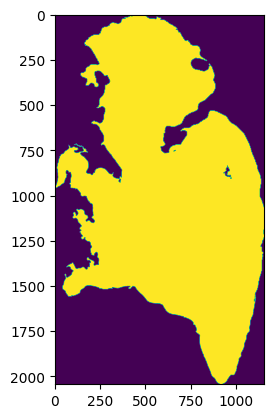

height, width= 197 348
mask_coords [265, 595, 100, 130]
348 197 265 1886 595 1870
(1986, 2000)
height, width= 197 348
mask_coords [660, 613, 123, 108]
348 197 660 1863 613 1892
(1986, 2000)
height, width= 197 348
mask_coords [754, 585, 197, 348]
348 197 754 1789 585 1652
(1986, 2000)
height, width= 197 348
mask_coords [1117, 893, 27, 33]
348 197 1117 1959 893 1967
(1986, 2000)


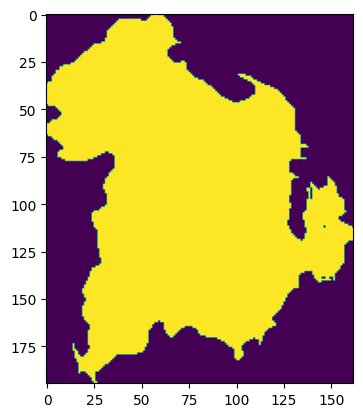

height, width= 27 33
mask_coords [265, 595, 100, 130]
33 27 265 1886 595 1870
(1986, 2000)
height, width= 27 33
mask_coords [660, 613, 123, 108]
33 27 660 1863 613 1892
(1986, 2000)
height, width= 27 33
mask_coords [754, 585, 197, 348]
33 27 754 1789 585 1652
(1986, 2000)
height, width= 27 33
mask_coords [1117, 893, 27, 33]
33 27 1117 1959 893 1967
(1986, 2000)


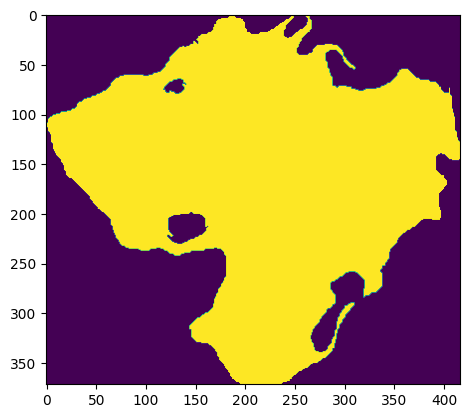

height, width= 71 63
mask_coords [219, 574, 71, 63]
63 71 219 1915 574 1937
(1986, 2000)
height, width= 71 63
mask_coords [646, 629, 88, 146]
63 71 646 1898 629 1854
(1986, 2000)
height, width= 71 63
mask_coords [715, 542, 52, 72]
63 71 715 1934 542 1928
(1986, 2000)
height, width= 71 63
mask_coords [739, 652, 53, 34]
63 71 739 1933 652 1966
(1986, 2000)
height, width= 71 63
mask_coords [870, 490, 376, 656]
63 71 870 1610 490 1344
(1986, 2000)


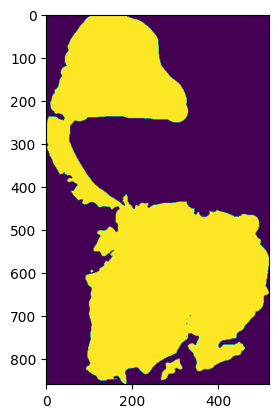

height, width= 88 146
mask_coords [219, 574, 71, 63]
146 88 219 1915 574 1937
(1986, 2000)
height, width= 88 146
mask_coords [646, 629, 88, 146]
146 88 646 1898 629 1854
(1986, 2000)
height, width= 88 146
mask_coords [715, 542, 52, 72]
146 88 715 1934 542 1928
(1986, 2000)
height, width= 88 146
mask_coords [739, 652, 53, 34]
146 88 739 1933 652 1966
(1986, 2000)
height, width= 88 146
mask_coords [870, 490, 376, 656]
146 88 870 1610 490 1344
(1986, 2000)


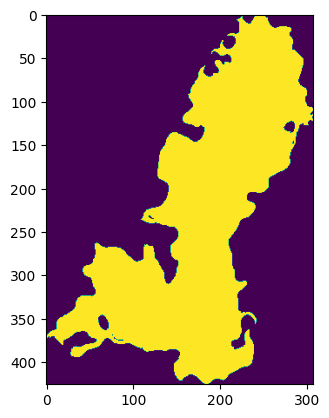

height, width= 52 72
mask_coords [219, 574, 71, 63]
72 52 219 1915 574 1937
(1986, 2000)
height, width= 52 72
mask_coords [646, 629, 88, 146]
72 52 646 1898 629 1854
(1986, 2000)
height, width= 52 72
mask_coords [715, 542, 52, 72]
72 52 715 1934 542 1928
(1986, 2000)
height, width= 52 72
mask_coords [739, 652, 53, 34]
72 52 739 1933 652 1966
(1986, 2000)
height, width= 52 72
mask_coords [870, 490, 376, 656]
72 52 870 1610 490 1344
(1986, 2000)


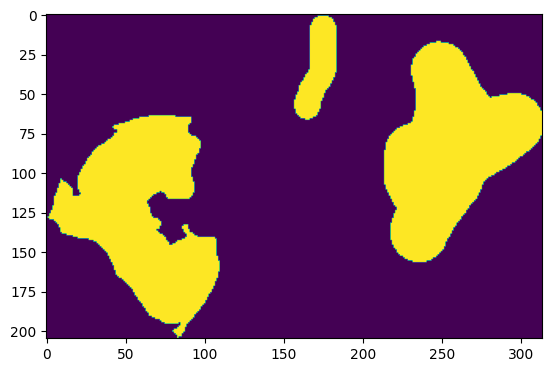

height, width= 53 34
mask_coords [219, 574, 71, 63]
34 53 219 1915 574 1937
(1986, 2000)
height, width= 53 34
mask_coords [646, 629, 88, 146]
34 53 646 1898 629 1854
(1986, 2000)
height, width= 53 34
mask_coords [715, 542, 52, 72]
34 53 715 1934 542 1928
(1986, 2000)
height, width= 53 34
mask_coords [739, 652, 53, 34]
34 53 739 1933 652 1966
(1986, 2000)
height, width= 53 34
mask_coords [870, 490, 376, 656]
34 53 870 1610 490 1344
(1986, 2000)


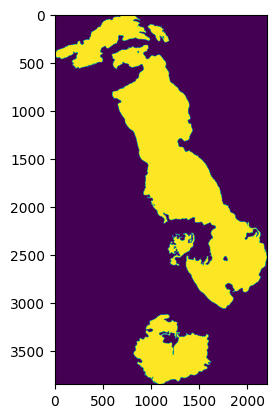

height, width= 376 656
mask_coords [219, 574, 71, 63]
656 376 219 1915 574 1937
(1986, 2000)
height, width= 376 656
mask_coords [646, 629, 88, 146]
656 376 646 1898 629 1854
(1986, 2000)
height, width= 376 656
mask_coords [715, 542, 52, 72]
656 376 715 1934 542 1928
(1986, 2000)
height, width= 376 656
mask_coords [739, 652, 53, 34]
656 376 739 1933 652 1966
(1986, 2000)
height, width= 376 656
mask_coords [870, 490, 376, 656]
656 376 870 1610 490 1344
(1986, 2000)


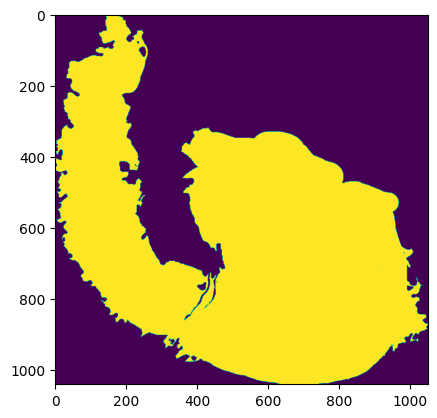

height, width= 179 177
mask_coords [714, 788, 179, 177]
177 179 714 1807 788 1823
(1986, 2000)
height, width= 179 177
mask_coords [1120, 653, 135, 153]
177 179 1120 1851 653 1847
(1986, 2000)


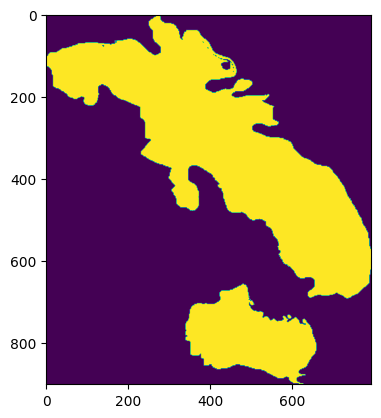

height, width= 135 153
mask_coords [714, 788, 179, 177]
153 135 714 1807 788 1823
(1986, 2000)
height, width= 135 153
mask_coords [1120, 653, 135, 153]
153 135 1120 1851 653 1847
(1986, 2000)


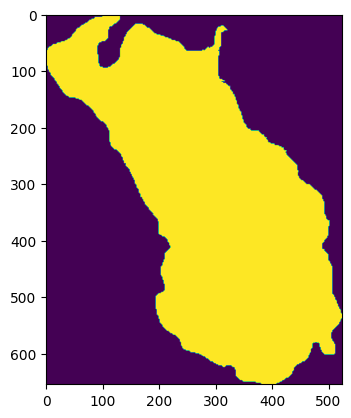

height, width= 89 111
mask_coords [923, 665, 89, 111]
111 89 923 1897 665 1889
(1986, 2000)
(2000, 1986)
[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1997 1997 1997 ... 1997 1997 1997]
 [1998 1998 1998 ... 1998 1998 1998]
 [1999 1999 1999 ... 1999 1999 1999]] [[   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 ...
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]]
(202.30473102, 1816.9013501099998)
(224.07169574999998, 1804.5240564399999)
(202.30473102, 1792.14676277)
(223.64489251999998, 1779.7694691)
(202.30473102, 1767.39217543)
(223.64489251999998, 1754.5880785299998)
(202.30473102, 1742.2107848599999)
(223.64489251999998, 1729.83349119)
(202.30473102, 1717.45619752)
(223.64489251999998, 1705.07890385)
(202.30473102, 1692.70161018)
(223.64489251999998, 1680.32431651)
(201.87792779, 1667.9470

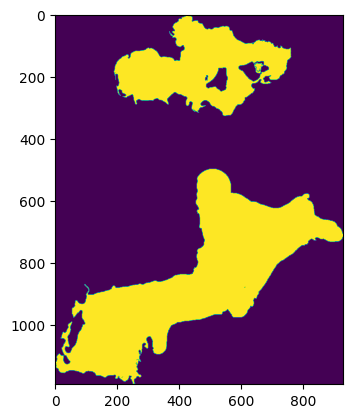

height, width= 158 203
mask_coords [1035, 538, 158, 203]
203 158 1035 1828 538 1797
(1986, 2000)
height, width= 158 203
mask_coords [1193, 945, 91, 78]
203 158 1193 1895 945 1922
(1986, 2000)


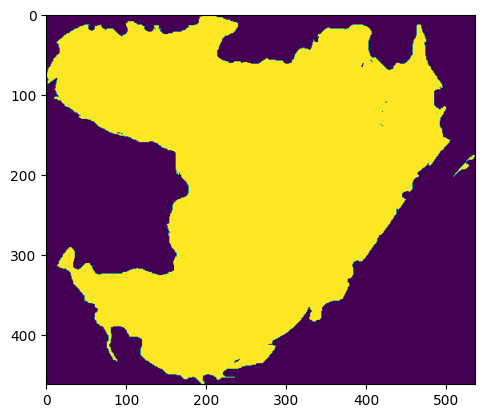

height, width= 91 78
mask_coords [1035, 538, 158, 203]
78 91 1035 1828 538 1797
(1986, 2000)
height, width= 91 78
mask_coords [1193, 945, 91, 78]
78 91 1193 1895 945 1922
(1986, 2000)


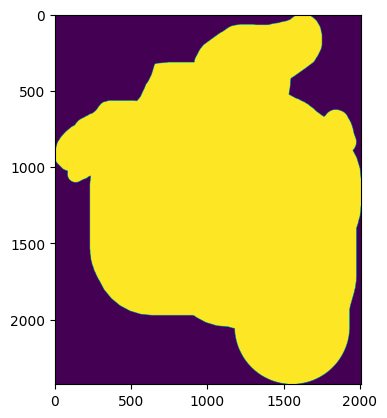

height, width= 342 413
mask_coords [489, 531, 342, 414]
413 342 489 1644 531 1586
(1986, 2000)


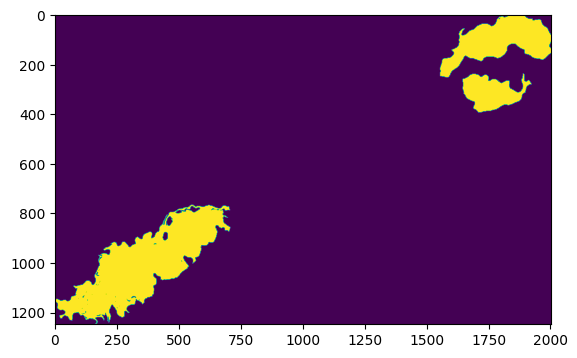

height, width= 341 213
mask_coords [431, 467, 341, 213]
213 341 431 1645 467 1787
(1986, 2000)
height, width= 341 213
mask_coords [938, 323, 517, 735]
213 341 938 1469 323 1265
(1986, 2000)


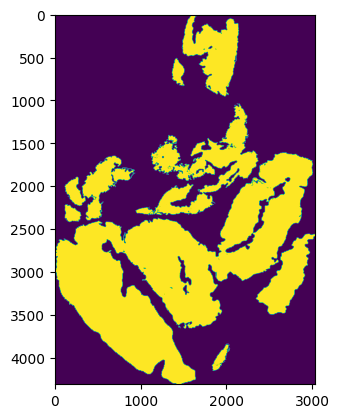

height, width= 517 735
mask_coords [431, 467, 341, 213]
735 517 431 1645 467 1787
(1986, 2000)
height, width= 517 735
mask_coords [938, 323, 517, 735]
735 517 938 1469 323 1265
(1986, 2000)
(2000, 1986)
[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1997 1997 1997 ... 1997 1997 1997]
 [1998 1998 1998 ... 1998 1998 1998]
 [1999 1999 1999 ... 1999 1999 1999]] [[   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 ...
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]]
(202.30473102, 1816.9013501099998)
(224.07169574999998, 1804.5240564399999)
(202.30473102, 1792.14676277)
(223.64489251999998, 1779.7694691)
(202.30473102, 1767.39217543)
(223.64489251999998, 1754.5880785299998)
(202.30473102, 1742.2107848599999)
(223.64489251999998, 1729.83349119)
(202.30473102, 1717.45619752)
(223.64489251999998, 1705.07

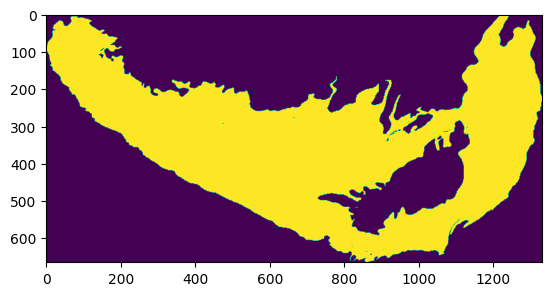

height, width= 227 113
mask_coords [230, 984, 227, 113]
113 227 230 1759 984 1887
(1986, 2000)


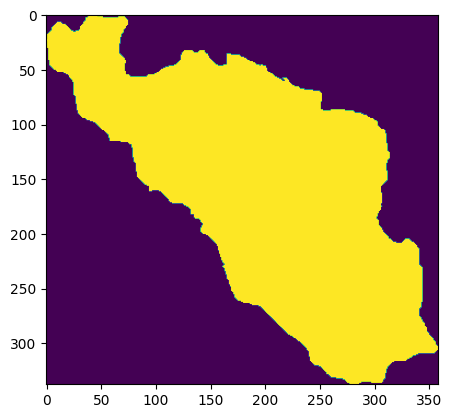

height, width= 61 57
mask_coords [696, 815, 61, 57]
57 61 696 1925 815 1943
(1986, 2000)


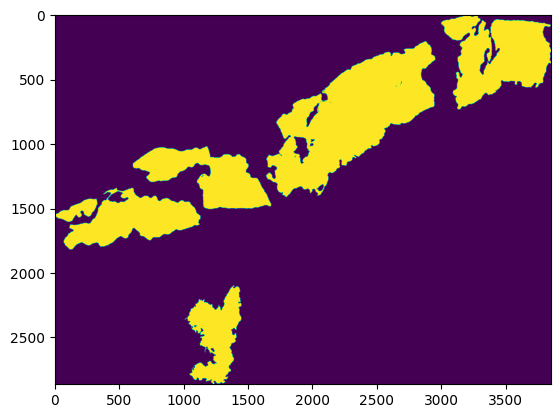

height, width= 657 489
mask_coords [372, 557, 657, 489]
489 657 372 1329 557 1511
(1986, 2000)
height, width= 657 489
mask_coords [837, 725, 234, 120]
489 657 837 1752 725 1880
(1986, 2000)


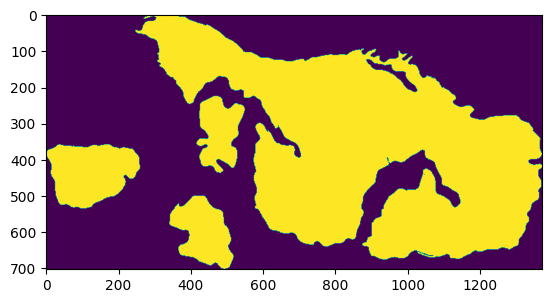

height, width= 234 120
mask_coords [372, 557, 657, 489]
120 234 372 1329 557 1511
(1986, 2000)
height, width= 234 120
mask_coords [837, 725, 234, 120]
120 234 837 1752 725 1880
(1986, 2000)
(2000, 1986)
[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1997 1997 1997 ... 1997 1997 1997]
 [1998 1998 1998 ... 1998 1998 1998]
 [1999 1999 1999 ... 1999 1999 1999]] [[   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 ...
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]]
(202.30473102, 1816.9013501099998)
(224.07169574999998, 1804.5240564399999)
(202.30473102, 1792.14676277)
(223.64489251999998, 1779.7694691)
(202.30473102, 1767.39217543)
(223.64489251999998, 1754.5880785299998)
(202.30473102, 1742.2107848599999)
(223.64489251999998, 1729.83349119)
(202.30473102, 1717.45619752)
(223.64489251999998, 1705.07

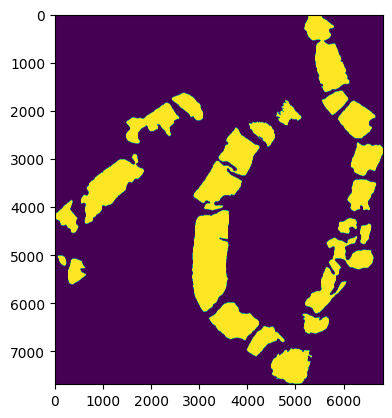

height, width= 1162 1311
mask_coords [141, 35, 1162, 1311]
1311 1162 141 824 35 689
(1986, 2000)
(2000, 1986)
[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1997 1997 1997 ... 1997 1997 1997]
 [1998 1998 1998 ... 1998 1998 1998]
 [1999 1999 1999 ... 1999 1999 1999]] [[   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 ...
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]]
(202.30473102, 1816.9013501099998)
(224.07169574999998, 1804.5240564399999)
(202.30473102, 1792.14676277)
(223.64489251999998, 1779.7694691)
(202.30473102, 1767.39217543)
(223.64489251999998, 1754.5880785299998)
(202.30473102, 1742.2107848599999)
(223.64489251999998, 1729.83349119)
(202.30473102, 1717.45619752)
(223.64489251999998, 1705.07890385)
(202.30473102, 1692.70161018)
(223.64489251999998, 1680.32431651)
(201.87792779, 1667

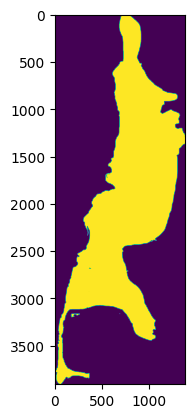

height, width= 235 667
mask_coords [66, 259, 235, 667]
667 235 66 1751 259 1333
(1986, 2000)
height, width= 235 667
mask_coords [604, 320, 57, 100]
667 235 604 1929 320 1900
(1986, 2000)
height, width= 235 667
mask_coords [652, 949, 141, 156]
667 235 652 1845 949 1844
(1986, 2000)
height, width= 235 667
mask_coords [773, 761, 144, 136]
667 235 773 1842 761 1864
(1986, 2000)
height, width= 235 667
mask_coords [889, 977, 153, 168]
667 235 889 1833 977 1832
(1986, 2000)
height, width= 235 667
mask_coords [932, 793, 145, 65]
667 235 932 1841 793 1935
(1986, 2000)


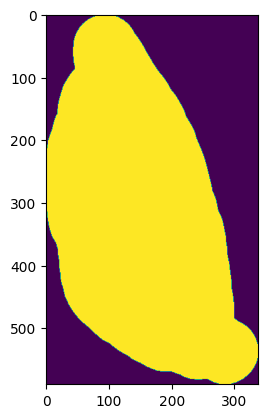

height, width= 57 100
mask_coords [66, 259, 235, 667]
100 57 66 1751 259 1333
(1986, 2000)
height, width= 57 100
mask_coords [604, 320, 57, 100]
100 57 604 1929 320 1900
(1986, 2000)
height, width= 57 100
mask_coords [652, 949, 141, 156]
100 57 652 1845 949 1844
(1986, 2000)
height, width= 57 100
mask_coords [773, 761, 144, 136]
100 57 773 1842 761 1864
(1986, 2000)
height, width= 57 100
mask_coords [889, 977, 153, 168]
100 57 889 1833 977 1832
(1986, 2000)
height, width= 57 100
mask_coords [932, 793, 145, 65]
100 57 932 1841 793 1935
(1986, 2000)


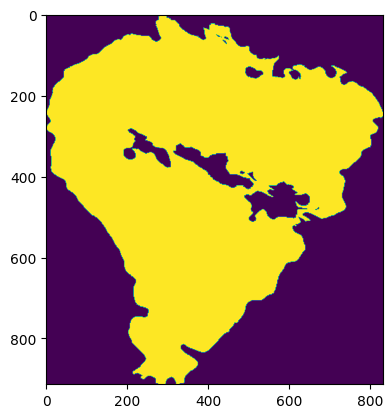

height, width= 142 156
mask_coords [66, 259, 235, 667]
156 142 66 1751 259 1333
(1986, 2000)
height, width= 142 156
mask_coords [604, 320, 57, 100]
156 142 604 1929 320 1900
(1986, 2000)
height, width= 142 156
mask_coords [652, 949, 141, 156]
156 142 652 1845 949 1844
(1986, 2000)
height, width= 142 156
mask_coords [773, 761, 144, 136]
156 142 773 1842 761 1864
(1986, 2000)
height, width= 142 156
mask_coords [889, 977, 153, 168]
156 142 889 1833 977 1832
(1986, 2000)
height, width= 142 156
mask_coords [932, 793, 145, 65]
156 142 932 1841 793 1935
(1986, 2000)


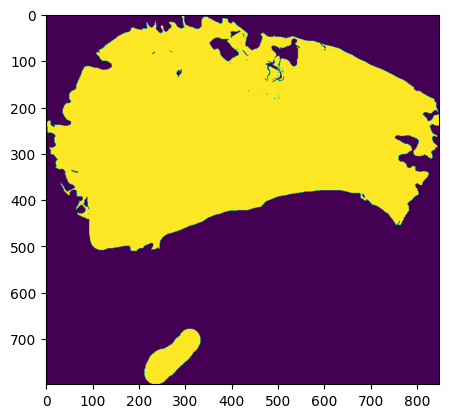

height, width= 144 136
mask_coords [66, 259, 235, 667]
136 144 66 1751 259 1333
(1986, 2000)
height, width= 144 136
mask_coords [604, 320, 57, 100]
136 144 604 1929 320 1900
(1986, 2000)
height, width= 144 136
mask_coords [652, 949, 141, 156]
136 144 652 1845 949 1844
(1986, 2000)
height, width= 144 136
mask_coords [773, 761, 144, 136]
136 144 773 1842 761 1864
(1986, 2000)
height, width= 144 136
mask_coords [889, 977, 153, 168]
136 144 889 1833 977 1832
(1986, 2000)
height, width= 144 136
mask_coords [932, 793, 145, 65]
136 144 932 1841 793 1935
(1986, 2000)


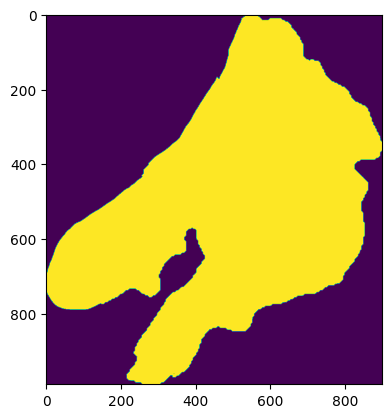

height, width= 153 169
mask_coords [66, 259, 235, 667]
169 153 66 1751 259 1333
(1986, 2000)
height, width= 153 169
mask_coords [604, 320, 57, 100]
169 153 604 1929 320 1900
(1986, 2000)
height, width= 153 169
mask_coords [652, 949, 141, 156]
169 153 652 1845 949 1844
(1986, 2000)
height, width= 153 169
mask_coords [773, 761, 144, 136]
169 153 773 1842 761 1864
(1986, 2000)
height, width= 153 169
mask_coords [889, 977, 153, 168]
169 153 889 1833 977 1832
(1986, 2000)
height, width= 153 169
mask_coords [932, 793, 145, 65]
169 153 932 1841 793 1935
(1986, 2000)


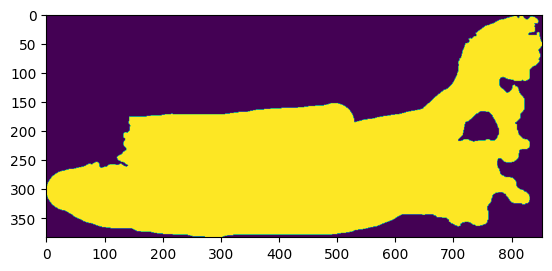

height, width= 145 65
mask_coords [66, 259, 235, 667]
65 145 66 1751 259 1333
(1986, 2000)
height, width= 145 65
mask_coords [604, 320, 57, 100]
65 145 604 1929 320 1900
(1986, 2000)
height, width= 145 65
mask_coords [652, 949, 141, 156]
65 145 652 1845 949 1844
(1986, 2000)
height, width= 145 65
mask_coords [773, 761, 144, 136]
65 145 773 1842 761 1864
(1986, 2000)
height, width= 145 65
mask_coords [889, 977, 153, 168]
65 145 889 1833 977 1832
(1986, 2000)
height, width= 145 65
mask_coords [932, 793, 145, 65]
65 145 932 1841 793 1935
(1986, 2000)


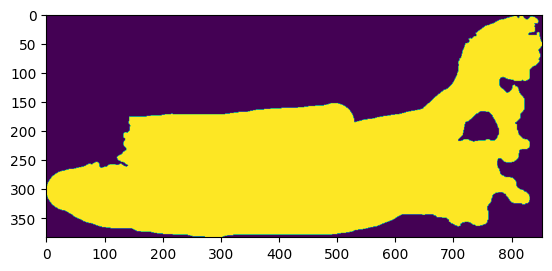

height, width= 145 65
mask_coords [932, 793, 145, 65]
65 145 932 1841 793 1935
(1986, 2000)
height, width= 145 65
mask_coords [224, 268, 53, 120]
65 145 224 1933 268 1880
(1986, 2000)
height, width= 145 65
mask_coords [443, 252, 245, 363]
65 145 443 1741 252 1637
(1986, 2000)
height, width= 145 65
mask_coords [704, 819, 192, 154]
65 145 704 1794 819 1846
(1986, 2000)
height, width= 145 65
mask_coords [851, 675, 224, 146]
65 145 851 1762 675 1854
(1986, 2000)


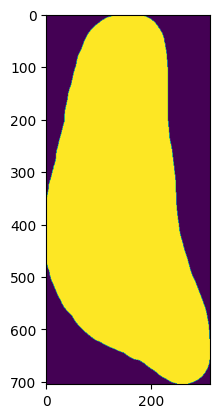

height, width= 53 120
mask_coords [932, 793, 145, 65]
120 53 932 1841 793 1935
(1986, 2000)
height, width= 53 120
mask_coords [224, 268, 53, 120]
120 53 224 1933 268 1880
(1986, 2000)
height, width= 53 120
mask_coords [443, 252, 245, 363]
120 53 443 1741 252 1637
(1986, 2000)
height, width= 53 120
mask_coords [704, 819, 192, 154]
120 53 704 1794 819 1846
(1986, 2000)
height, width= 53 120
mask_coords [851, 675, 224, 146]
120 53 851 1762 675 1854
(1986, 2000)


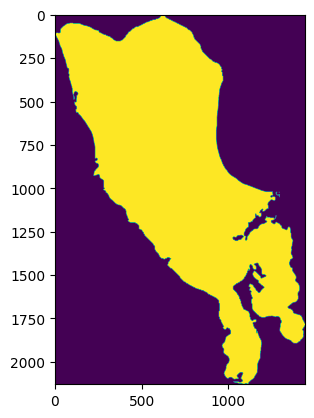

height, width= 245 363
mask_coords [932, 793, 145, 65]
363 245 932 1841 793 1935
(1986, 2000)
height, width= 245 363
mask_coords [224, 268, 53, 120]
363 245 224 1933 268 1880
(1986, 2000)
height, width= 245 363
mask_coords [443, 252, 245, 363]
363 245 443 1741 252 1637
(1986, 2000)
height, width= 245 363
mask_coords [704, 819, 192, 154]
363 245 704 1794 819 1846
(1986, 2000)
height, width= 245 363
mask_coords [851, 675, 224, 146]
363 245 851 1762 675 1854
(1986, 2000)


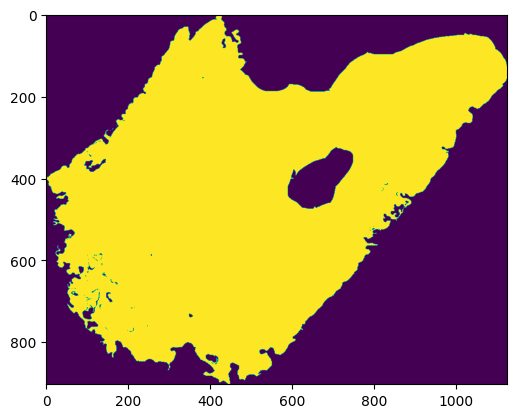

height, width= 192 154
mask_coords [932, 793, 145, 65]
154 192 932 1841 793 1935
(1986, 2000)
height, width= 192 154
mask_coords [224, 268, 53, 120]
154 192 224 1933 268 1880
(1986, 2000)
height, width= 192 154
mask_coords [443, 252, 245, 363]
154 192 443 1741 252 1637
(1986, 2000)
height, width= 192 154
mask_coords [704, 819, 192, 154]
154 192 704 1794 819 1846
(1986, 2000)
height, width= 192 154
mask_coords [851, 675, 224, 146]
154 192 851 1762 675 1854
(1986, 2000)


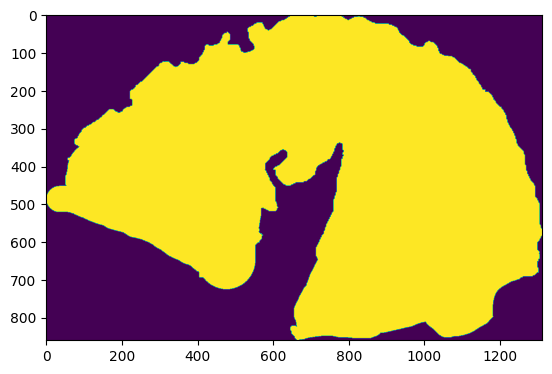

height, width= 223 146
mask_coords [932, 793, 145, 65]
146 223 932 1841 793 1935
(1986, 2000)
height, width= 223 146
mask_coords [224, 268, 53, 120]
146 223 224 1933 268 1880
(1986, 2000)
height, width= 223 146
mask_coords [443, 252, 245, 363]
146 223 443 1741 252 1637
(1986, 2000)
height, width= 223 146
mask_coords [704, 819, 192, 154]
146 223 704 1794 819 1846
(1986, 2000)
height, width= 223 146
mask_coords [851, 675, 224, 146]
146 223 851 1762 675 1854
(1986, 2000)


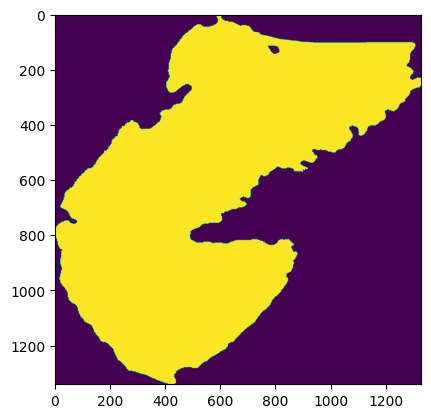

height, width= 226 228
mask_coords [819, 845, 226, 228]
228 226 819 1760 845 1772
(1986, 2000)
height, width= 226 228
mask_coords [1087, 456, 409, 513]
228 226 1087 1577 456 1487
(1986, 2000)


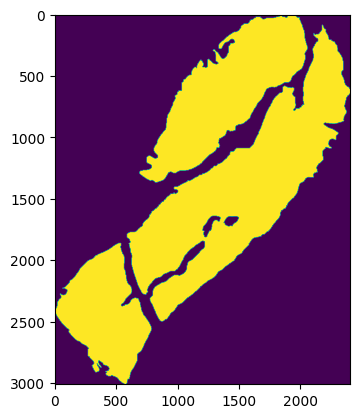

height, width= 409 514
mask_coords [819, 845, 226, 228]
514 409 819 1760 845 1772
(1986, 2000)
height, width= 409 514
mask_coords [1087, 456, 409, 513]
514 409 1087 1577 456 1487
(1986, 2000)
(2000, 1986)
[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1997 1997 1997 ... 1997 1997 1997]
 [1998 1998 1998 ... 1998 1998 1998]
 [1999 1999 1999 ... 1999 1999 1999]] [[   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 ...
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]]
(202.30473102, 1816.9013501099998)
(224.07169574999998, 1804.5240564399999)
(202.30473102, 1792.14676277)
(223.64489251999998, 1779.7694691)
(202.30473102, 1767.39217543)
(223.64489251999998, 1754.5880785299998)
(202.30473102, 1742.2107848599999)
(223.64489251999998, 1729.83349119)
(202.30473102, 1717.45619752)
(223.64489251999998, 1705.

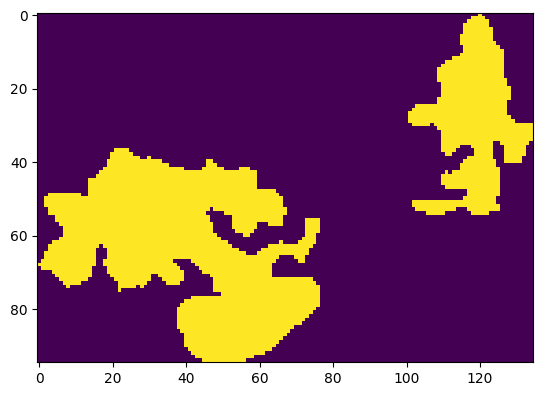

height, width= 23 16
mask_coords [206, 327, 23, 16]
16 23 206 1963 327 1984
(1986, 2000)
height, width= 23 16
mask_coords [316, 392, 22, 25]
16 23 316 1964 392 1975
(1986, 2000)
height, width= 23 16
mask_coords [340, 148, 124, 561]
16 23 340 1862 148 1439
(1986, 2000)
height, width= 23 16
mask_coords [598, 372, 189, 124]
16 23 598 1797 372 1876
(1986, 2000)
height, width= 23 16
mask_coords [813, 488, 58, 81]
16 23 813 1928 488 1919
(1986, 2000)


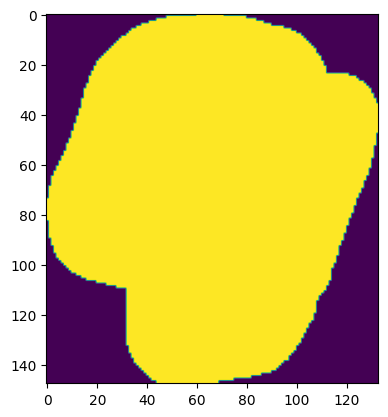

height, width= 22 25
mask_coords [206, 327, 23, 16]
25 22 206 1963 327 1984
(1986, 2000)
height, width= 22 25
mask_coords [316, 392, 22, 25]
25 22 316 1964 392 1975
(1986, 2000)
height, width= 22 25
mask_coords [340, 148, 124, 561]
25 22 340 1862 148 1439
(1986, 2000)
height, width= 22 25
mask_coords [598, 372, 189, 124]
25 22 598 1797 372 1876
(1986, 2000)
height, width= 22 25
mask_coords [813, 488, 58, 81]
25 22 813 1928 488 1919
(1986, 2000)


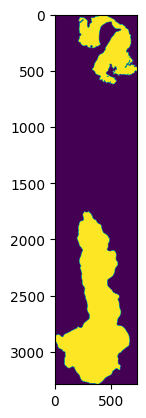

height, width= 124 561
mask_coords [206, 327, 23, 16]
561 124 206 1963 327 1984
(1986, 2000)
height, width= 124 561
mask_coords [316, 392, 22, 25]
561 124 316 1964 392 1975
(1986, 2000)
height, width= 124 561
mask_coords [340, 148, 124, 561]
561 124 340 1862 148 1439
(1986, 2000)
height, width= 124 561
mask_coords [598, 372, 189, 124]
561 124 598 1797 372 1876
(1986, 2000)
height, width= 124 561
mask_coords [813, 488, 58, 81]
561 124 813 1928 488 1919
(1986, 2000)


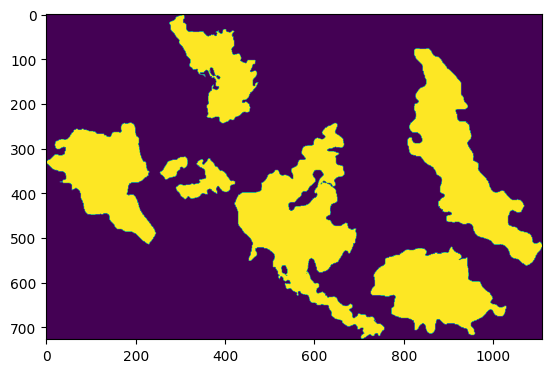

height, width= 189 124
mask_coords [206, 327, 23, 16]
124 189 206 1963 327 1984
(1986, 2000)
height, width= 189 124
mask_coords [316, 392, 22, 25]
124 189 316 1964 392 1975
(1986, 2000)
height, width= 189 124
mask_coords [340, 148, 124, 561]
124 189 340 1862 148 1439
(1986, 2000)
height, width= 189 124
mask_coords [598, 372, 189, 124]
124 189 598 1797 372 1876
(1986, 2000)
height, width= 189 124
mask_coords [813, 488, 58, 81]
124 189 813 1928 488 1919
(1986, 2000)


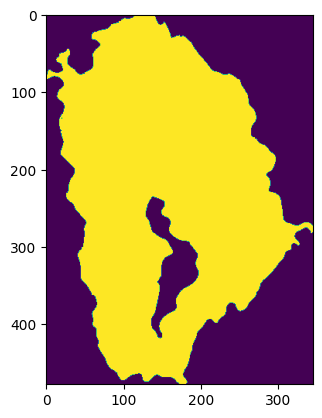

height, width= 58 81
mask_coords [206, 327, 23, 16]
81 58 206 1963 327 1984
(1986, 2000)
height, width= 58 81
mask_coords [316, 392, 22, 25]
81 58 316 1964 392 1975
(1986, 2000)
height, width= 58 81
mask_coords [340, 148, 124, 561]
81 58 340 1862 148 1439
(1986, 2000)
height, width= 58 81
mask_coords [598, 372, 189, 124]
81 58 598 1797 372 1876
(1986, 2000)
height, width= 58 81
mask_coords [813, 488, 58, 81]
81 58 813 1928 488 1919
(1986, 2000)


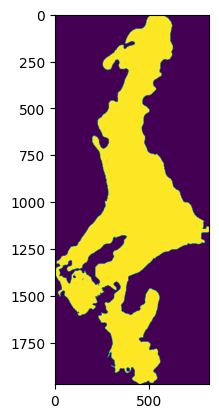

height, width= 140 336
mask_coords [71, 147, 140, 336]
336 140 71 1846 147 1664
(1986, 2000)
height, width= 140 336
mask_coords [289, 353, 68, 93]
336 140 289 1918 353 1907
(1986, 2000)
height, width= 140 336
mask_coords [364, 248, 56, 67]
336 140 364 1930 248 1933
(1986, 2000)
height, width= 140 336
mask_coords [407, 163, 24, 31]
336 140 407 1962 163 1969
(1986, 2000)


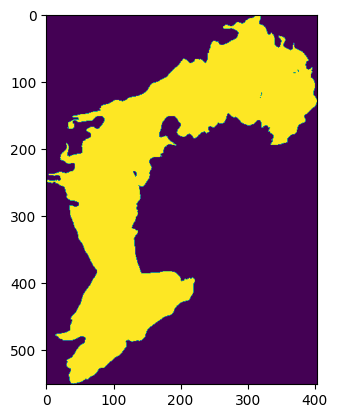

height, width= 68 94
mask_coords [71, 147, 140, 336]
94 68 71 1846 147 1664
(1986, 2000)
height, width= 68 94
mask_coords [289, 353, 68, 93]
94 68 289 1918 353 1907
(1986, 2000)
height, width= 68 94
mask_coords [364, 248, 56, 67]
94 68 364 1930 248 1933
(1986, 2000)
height, width= 68 94
mask_coords [407, 163, 24, 31]
94 68 407 1962 163 1969
(1986, 2000)


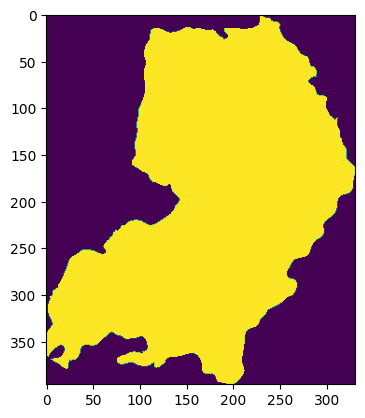

height, width= 56 67
mask_coords [71, 147, 140, 336]
67 56 71 1846 147 1664
(1986, 2000)
height, width= 56 67
mask_coords [289, 353, 68, 93]
67 56 289 1918 353 1907
(1986, 2000)
height, width= 56 67
mask_coords [364, 248, 56, 67]
67 56 364 1930 248 1933
(1986, 2000)
height, width= 56 67
mask_coords [407, 163, 24, 31]
67 56 407 1962 163 1969
(1986, 2000)


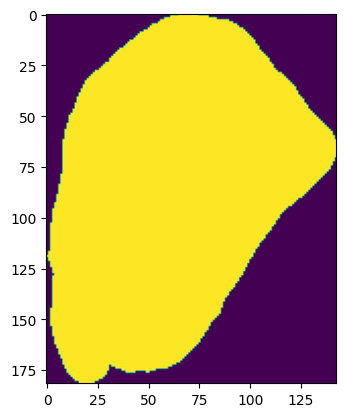

height, width= 24 31
mask_coords [71, 147, 140, 336]
31 24 71 1846 147 1664
(1986, 2000)
height, width= 24 31
mask_coords [289, 353, 68, 93]
31 24 289 1918 353 1907
(1986, 2000)
height, width= 24 31
mask_coords [364, 248, 56, 67]
31 24 364 1930 248 1933
(1986, 2000)
height, width= 24 31
mask_coords [407, 163, 24, 31]
31 24 407 1962 163 1969
(1986, 2000)
(2000, 1986)
[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1997 1997 1997 ... 1997 1997 1997]
 [1998 1998 1998 ... 1998 1998 1998]
 [1999 1999 1999 ... 1999 1999 1999]] [[   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 ...
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]]
(202.30473102, 1816.9013501099998)
(224.07169574999998, 1804.5240564399999)
(202.30473102, 1792.14676277)
(223.64489251999998, 1779.7694691)
(202.30473102, 1767.39217543)
(223

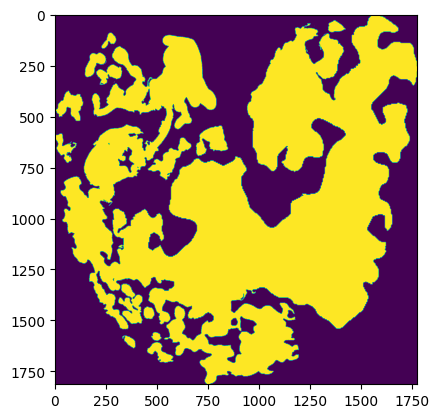

height, width= 303 309
mask_coords [613, 422, 303, 309]
309 303 613 1683 422 1691
(1986, 2000)
height, width= 303 309
mask_coords [707, 20, 168, 426]
309 303 707 1818 20 1574
(1986, 2000)
height, width= 303 309
mask_coords [756, 459, 14, 14]
309 303 756 1972 459 1986
(1986, 2000)


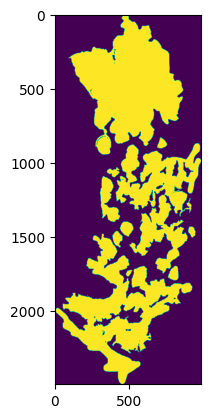

height, width= 168 426
mask_coords [613, 422, 303, 309]
426 168 613 1683 422 1691
(1986, 2000)
height, width= 168 426
mask_coords [707, 20, 168, 426]
426 168 707 1818 20 1574
(1986, 2000)
height, width= 168 426
mask_coords [756, 459, 14, 14]
426 168 756 1972 459 1986
(1986, 2000)


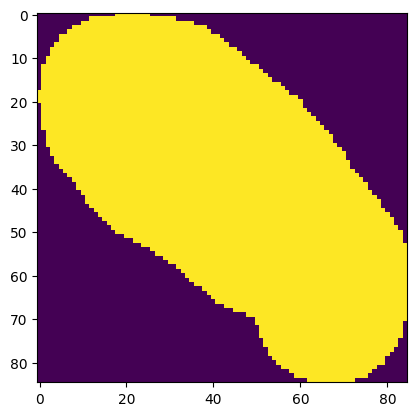

height, width= 14 14
mask_coords [613, 422, 303, 309]
14 14 613 1683 422 1691
(1986, 2000)
height, width= 14 14
mask_coords [707, 20, 168, 426]
14 14 707 1818 20 1574
(1986, 2000)
height, width= 14 14
mask_coords [756, 459, 14, 14]
14 14 756 1972 459 1986
(1986, 2000)


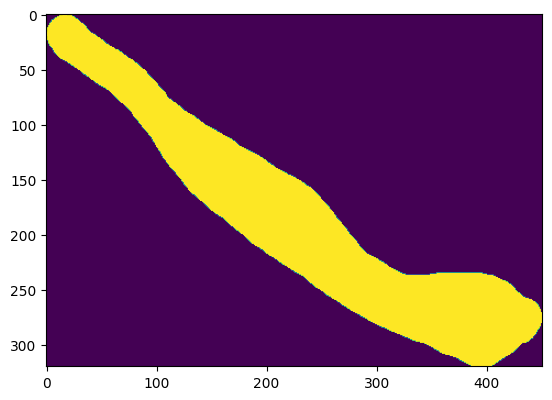

height, width= 76 54
mask_coords [314, 212, 76, 54]
54 76 314 1910 212 1946
(1986, 2000)
height, width= 76 54
mask_coords [632, 502, 64, 41]
54 76 632 1922 502 1959
(1986, 2000)
height, width= 76 54
mask_coords [684, 377, 97, 122]
54 76 684 1889 377 1878
(1986, 2000)
height, width= 76 54
mask_coords [734, 320, 39, 25]
54 76 734 1947 320 1975
(1986, 2000)
height, width= 76 54
mask_coords [833, 154, 34, 31]
54 76 833 1952 154 1969
(1986, 2000)


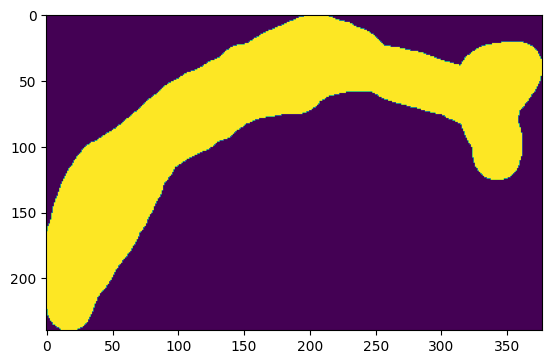

height, width= 64 40
mask_coords [314, 212, 76, 54]
40 64 314 1910 212 1946
(1986, 2000)
height, width= 64 40
mask_coords [632, 502, 64, 41]
40 64 632 1922 502 1959
(1986, 2000)
height, width= 64 40
mask_coords [684, 377, 97, 122]
40 64 684 1889 377 1878
(1986, 2000)
height, width= 64 40
mask_coords [734, 320, 39, 25]
40 64 734 1947 320 1975
(1986, 2000)
height, width= 64 40
mask_coords [833, 154, 34, 31]
40 64 833 1952 154 1969
(1986, 2000)


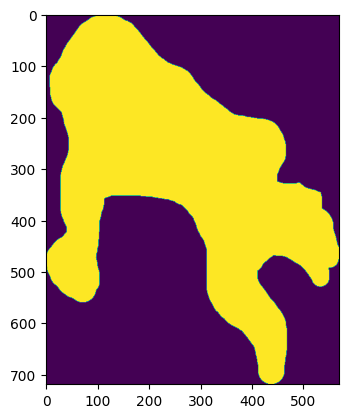

height, width= 97 122
mask_coords [314, 212, 76, 54]
122 97 314 1910 212 1946
(1986, 2000)
height, width= 97 122
mask_coords [632, 502, 64, 41]
122 97 632 1922 502 1959
(1986, 2000)
height, width= 97 122
mask_coords [684, 377, 97, 122]
122 97 684 1889 377 1878
(1986, 2000)
height, width= 97 122
mask_coords [734, 320, 39, 25]
122 97 734 1947 320 1975
(1986, 2000)
height, width= 97 122
mask_coords [833, 154, 34, 31]
122 97 833 1952 154 1969
(1986, 2000)


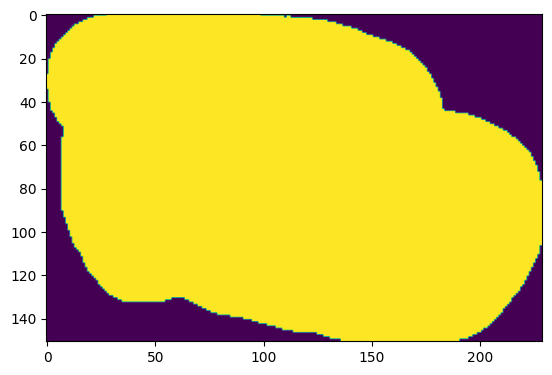

height, width= 39 25
mask_coords [314, 212, 76, 54]
25 39 314 1910 212 1946
(1986, 2000)
height, width= 39 25
mask_coords [632, 502, 64, 41]
25 39 632 1922 502 1959
(1986, 2000)
height, width= 39 25
mask_coords [684, 377, 97, 122]
25 39 684 1889 377 1878
(1986, 2000)
height, width= 39 25
mask_coords [734, 320, 39, 25]
25 39 734 1947 320 1975
(1986, 2000)
height, width= 39 25
mask_coords [833, 154, 34, 31]
25 39 833 1952 154 1969
(1986, 2000)


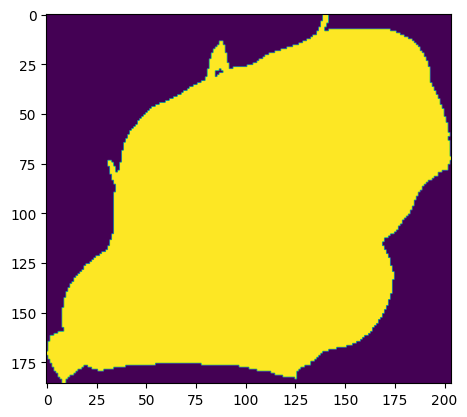

height, width= 34 31
mask_coords [314, 212, 76, 54]
31 34 314 1910 212 1946
(1986, 2000)
height, width= 34 31
mask_coords [632, 502, 64, 41]
31 34 632 1922 502 1959
(1986, 2000)
height, width= 34 31
mask_coords [684, 377, 97, 122]
31 34 684 1889 377 1878
(1986, 2000)
height, width= 34 31
mask_coords [734, 320, 39, 25]
31 34 734 1947 320 1975
(1986, 2000)
height, width= 34 31
mask_coords [833, 154, 34, 31]
31 34 833 1952 154 1969
(1986, 2000)


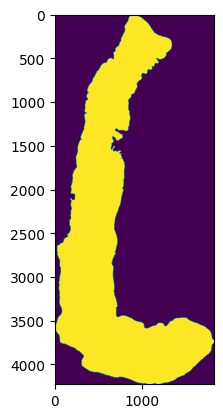

height, width= 310 721
mask_coords [149, 216, 309, 721]
721 310 149 1677 216 1279
(1986, 2000)
height, width= 310 721
mask_coords [338, 206, 59, 49]
721 310 338 1927 206 1951
(1986, 2000)


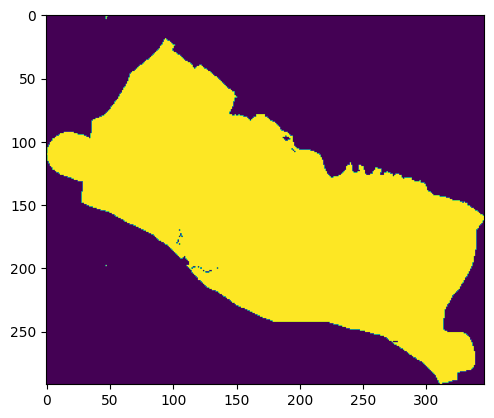

height, width= 59 49
mask_coords [149, 216, 309, 721]
49 59 149 1677 216 1279
(1986, 2000)
height, width= 59 49
mask_coords [338, 206, 59, 49]
49 59 338 1927 206 1951
(1986, 2000)
(2000, 1986)
[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1997 1997 1997 ... 1997 1997 1997]
 [1998 1998 1998 ... 1998 1998 1998]
 [1999 1999 1999 ... 1999 1999 1999]] [[   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 ...
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]]
(202.30473102, 1816.9013501099998)
(224.07169574999998, 1804.5240564399999)
(202.30473102, 1792.14676277)
(223.64489251999998, 1779.7694691)
(202.30473102, 1767.39217543)
(223.64489251999998, 1754.5880785299998)
(202.30473102, 1742.2107848599999)
(223.64489251999998, 1729.83349119)
(202.30473102, 1717.45619752)
(223.64489251999998, 1705.07890385)
(2

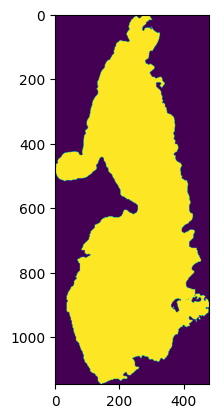

height, width= 81 195
mask_coords [190, 474, 81, 195]
195 81 190 1905 474 1805
(1986, 2000)
height, width= 81 195
mask_coords [215, 650, 90, 168]
195 81 215 1896 650 1832
(1986, 2000)
height, width= 81 195
mask_coords [393, 443, 113, 126]
195 81 393 1873 443 1874
(1986, 2000)
height, width= 81 195
mask_coords [474, 601, 251, 320]
195 81 474 1735 601 1680
(1986, 2000)
height, width= 81 195
mask_coords [715, 176, 150, 96]
195 81 715 1836 176 1904
(1986, 2000)
height, width= 81 195
mask_coords [832, 341, 89, 110]
195 81 832 1897 341 1890
(1986, 2000)


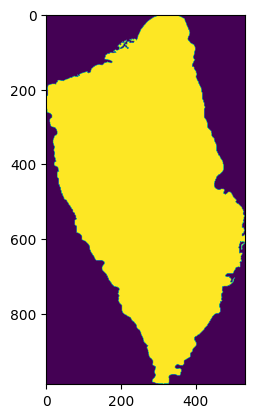

height, width= 90 169
mask_coords [190, 474, 81, 195]
169 90 190 1905 474 1805
(1986, 2000)
height, width= 90 169
mask_coords [215, 650, 90, 168]
169 90 215 1896 650 1832
(1986, 2000)
height, width= 90 169
mask_coords [393, 443, 113, 126]
169 90 393 1873 443 1874
(1986, 2000)
height, width= 90 169
mask_coords [474, 601, 251, 320]
169 90 474 1735 601 1680
(1986, 2000)
height, width= 90 169
mask_coords [715, 176, 150, 96]
169 90 715 1836 176 1904
(1986, 2000)
height, width= 90 169
mask_coords [832, 341, 89, 110]
169 90 832 1897 341 1890
(1986, 2000)


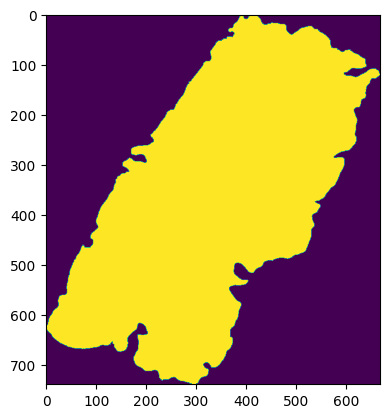

height, width= 113 126
mask_coords [190, 474, 81, 195]
126 113 190 1905 474 1805
(1986, 2000)
height, width= 113 126
mask_coords [215, 650, 90, 168]
126 113 215 1896 650 1832
(1986, 2000)
height, width= 113 126
mask_coords [393, 443, 113, 126]
126 113 393 1873 443 1874
(1986, 2000)
height, width= 113 126
mask_coords [474, 601, 251, 320]
126 113 474 1735 601 1680
(1986, 2000)
height, width= 113 126
mask_coords [715, 176, 150, 96]
126 113 715 1836 176 1904
(1986, 2000)
height, width= 113 126
mask_coords [832, 341, 89, 110]
126 113 832 1897 341 1890
(1986, 2000)


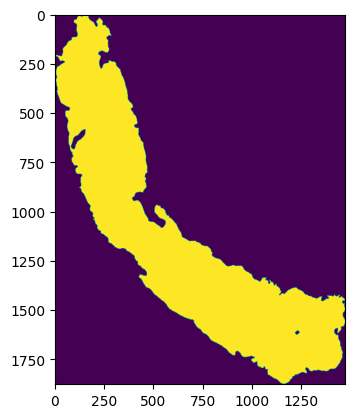

height, width= 251 320
mask_coords [190, 474, 81, 195]
320 251 190 1905 474 1805
(1986, 2000)
height, width= 251 320
mask_coords [215, 650, 90, 168]
320 251 215 1896 650 1832
(1986, 2000)
height, width= 251 320
mask_coords [393, 443, 113, 126]
320 251 393 1873 443 1874
(1986, 2000)
height, width= 251 320
mask_coords [474, 601, 251, 320]
320 251 474 1735 601 1680
(1986, 2000)
height, width= 251 320
mask_coords [715, 176, 150, 96]
320 251 715 1836 176 1904
(1986, 2000)
height, width= 251 320
mask_coords [832, 341, 89, 110]
320 251 832 1897 341 1890
(1986, 2000)


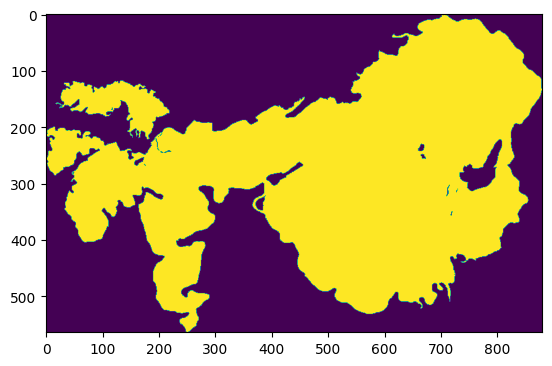

height, width= 150 96
mask_coords [190, 474, 81, 195]
96 150 190 1905 474 1805
(1986, 2000)
height, width= 150 96
mask_coords [215, 650, 90, 168]
96 150 215 1896 650 1832
(1986, 2000)
height, width= 150 96
mask_coords [393, 443, 113, 126]
96 150 393 1873 443 1874
(1986, 2000)
height, width= 150 96
mask_coords [474, 601, 251, 320]
96 150 474 1735 601 1680
(1986, 2000)
height, width= 150 96
mask_coords [715, 176, 150, 96]
96 150 715 1836 176 1904
(1986, 2000)
height, width= 150 96
mask_coords [832, 341, 89, 110]
96 150 832 1897 341 1890
(1986, 2000)


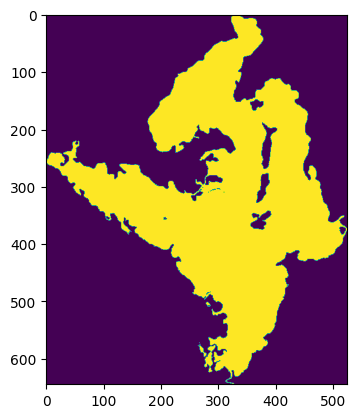

height, width= 89 110
mask_coords [190, 474, 81, 195]
110 89 190 1905 474 1805
(1986, 2000)
height, width= 89 110
mask_coords [215, 650, 90, 168]
110 89 215 1896 650 1832
(1986, 2000)
height, width= 89 110
mask_coords [393, 443, 113, 126]
110 89 393 1873 443 1874
(1986, 2000)
height, width= 89 110
mask_coords [474, 601, 251, 320]
110 89 474 1735 601 1680
(1986, 2000)
height, width= 89 110
mask_coords [715, 176, 150, 96]
110 89 715 1836 176 1904
(1986, 2000)
height, width= 89 110
mask_coords [832, 341, 89, 110]
110 89 832 1897 341 1890
(1986, 2000)


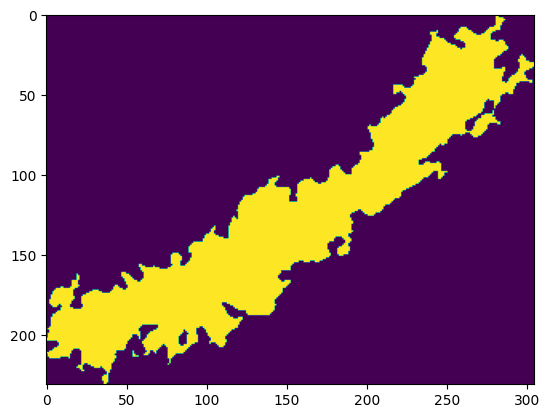

height, width= 52 39
mask_coords [216, 640, 51, 39]
39 52 216 1935 640 1961
(1986, 2000)
height, width= 52 39
mask_coords [708, 112, 108, 92]
39 52 708 1878 112 1908
(1986, 2000)
height, width= 52 39
mask_coords [756, 382, 124, 102]
39 52 756 1862 382 1898
(1986, 2000)


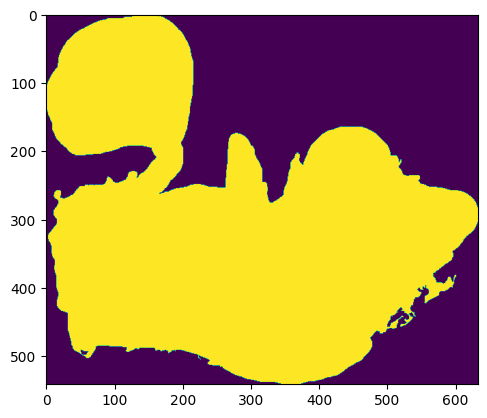

height, width= 108 92
mask_coords [216, 640, 51, 39]
92 108 216 1935 640 1961
(1986, 2000)
height, width= 108 92
mask_coords [708, 112, 108, 92]
92 108 708 1878 112 1908
(1986, 2000)
height, width= 108 92
mask_coords [756, 382, 124, 102]
92 108 756 1862 382 1898
(1986, 2000)


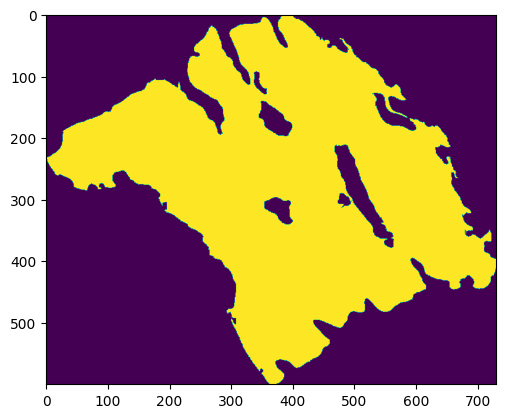

height, width= 124 102
mask_coords [216, 640, 51, 39]
102 124 216 1935 640 1961
(1986, 2000)
height, width= 124 102
mask_coords [708, 112, 108, 92]
102 124 708 1878 112 1908
(1986, 2000)
height, width= 124 102
mask_coords [756, 382, 124, 102]
102 124 756 1862 382 1898
(1986, 2000)


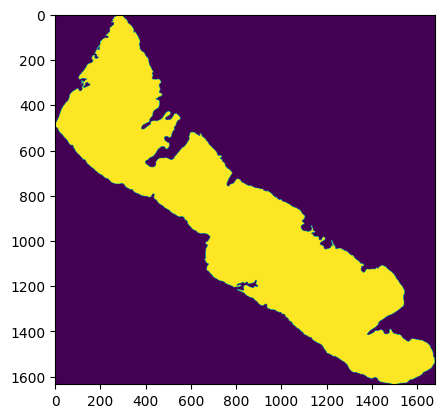

height, width= 286 278
mask_coords [267, 750, 286, 279]
278 286 267 1700 750 1721
(1986, 2000)
height, width= 286 278
mask_coords [692, 90, 81, 25]
278 286 692 1905 90 1975
(1986, 2000)
height, width= 286 278
mask_coords [735, 431, 78, 61]
278 286 735 1908 431 1939
(1986, 2000)
height, width= 286 278
mask_coords [888, 582, 106, 92]
278 286 888 1880 582 1908
(1986, 2000)


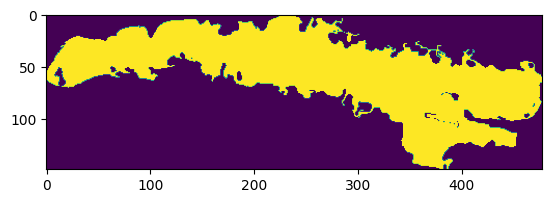

height, width= 81 25
mask_coords [267, 750, 286, 279]
25 81 267 1700 750 1721
(1986, 2000)
height, width= 81 25
mask_coords [692, 90, 81, 25]
25 81 692 1905 90 1975
(1986, 2000)
height, width= 81 25
mask_coords [735, 431, 78, 61]
25 81 735 1908 431 1939
(1986, 2000)
height, width= 81 25
mask_coords [888, 582, 106, 92]
25 81 888 1880 582 1908
(1986, 2000)


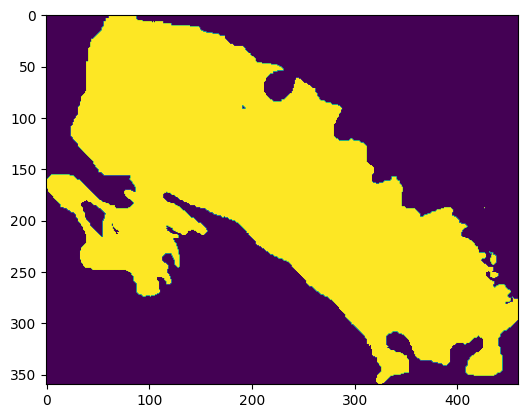

height, width= 78 61
mask_coords [267, 750, 286, 279]
61 78 267 1700 750 1721
(1986, 2000)
height, width= 78 61
mask_coords [692, 90, 81, 25]
61 78 692 1905 90 1975
(1986, 2000)
height, width= 78 61
mask_coords [735, 431, 78, 61]
61 78 735 1908 431 1939
(1986, 2000)
height, width= 78 61
mask_coords [888, 582, 106, 92]
61 78 888 1880 582 1908
(1986, 2000)


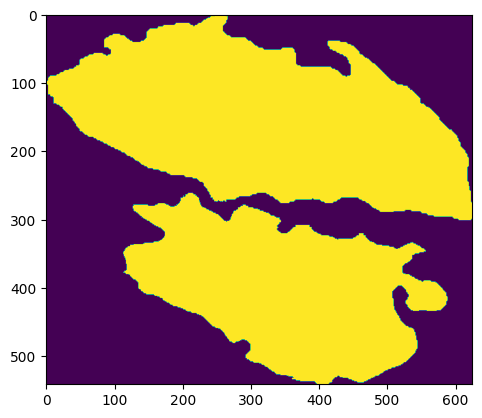

height, width= 106 92
mask_coords [267, 750, 286, 279]
92 106 267 1700 750 1721
(1986, 2000)
height, width= 106 92
mask_coords [692, 90, 81, 25]
92 106 692 1905 90 1975
(1986, 2000)
height, width= 106 92
mask_coords [735, 431, 78, 61]
92 106 735 1908 431 1939
(1986, 2000)
height, width= 106 92
mask_coords [888, 582, 106, 92]
92 106 888 1880 582 1908
(1986, 2000)
(2000, 1986)
[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1997 1997 1997 ... 1997 1997 1997]
 [1998 1998 1998 ... 1998 1998 1998]
 [1999 1999 1999 ... 1999 1999 1999]] [[   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 ...
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]]
(202.30473102, 1816.9013501099998)
(224.07169574999998, 1804.5240564399999)
(202.30473102, 1792.14676277)
(223.64489251999998, 1779.7694691)
(202.30473102, 1767.39217

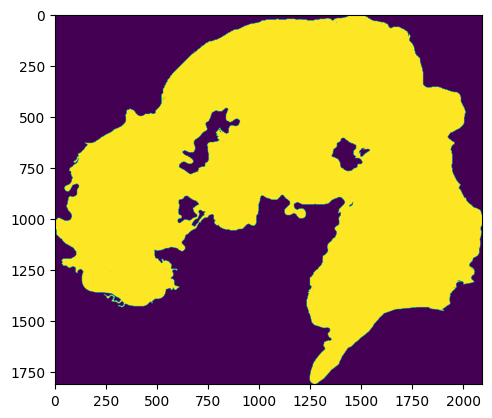

height, width= 357 309
mask_coords [690, 473, 357, 309]
309 357 690 1629 473 1691
(1986, 2000)
height, width= 357 309
mask_coords [807, 1093, 316, 445]
309 357 807 1670 1093 1555
(1986, 2000)


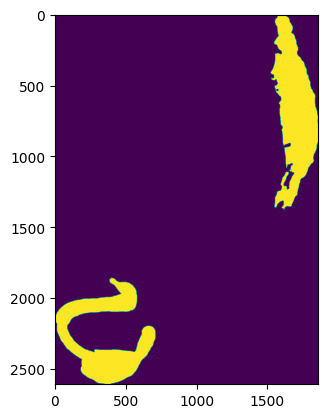

height, width= 316 445
mask_coords [690, 473, 357, 309]
445 316 690 1629 473 1691
(1986, 2000)
height, width= 316 445
mask_coords [807, 1093, 316, 445]
445 316 807 1670 1093 1555
(1986, 2000)


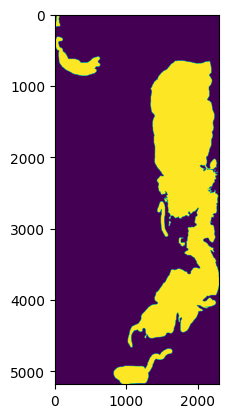

height, width= 393 884
mask_coords [686, 612, 393, 884]
884 393 686 1593 612 1116
(1986, 2000)
(2000, 1986)
[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1997 1997 1997 ... 1997 1997 1997]
 [1998 1998 1998 ... 1998 1998 1998]
 [1999 1999 1999 ... 1999 1999 1999]] [[   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 ...
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]]
(202.30473102, 1816.9013501099998)
(224.07169574999998, 1804.5240564399999)
(202.30473102, 1792.14676277)
(223.64489251999998, 1779.7694691)
(202.30473102, 1767.39217543)
(223.64489251999998, 1754.5880785299998)
(202.30473102, 1742.2107848599999)
(223.64489251999998, 1729.83349119)
(202.30473102, 1717.45619752)
(223.64489251999998, 1705.07890385)
(202.30473102, 1692.70161018)
(223.64489251999998, 1680.32431651)
(201.87792779, 1667.9

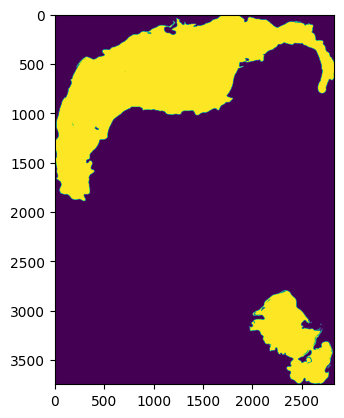

height, width= 483 639
mask_coords [272, 604, 483, 639]
639 483 272 1503 604 1361
(1986, 2000)


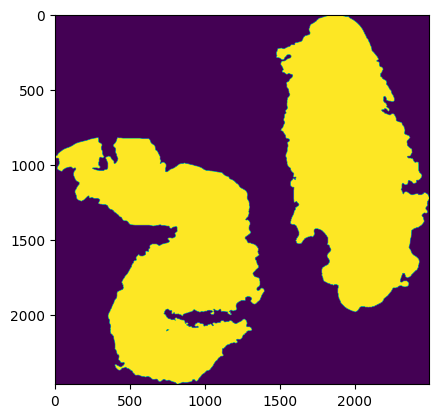

height, width= 425 420
mask_coords [370, 763, 425, 420]
420 425 370 1561 763 1580
(1986, 2000)


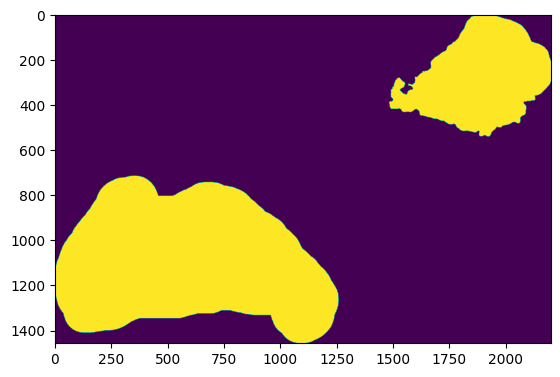

height, width= 375 248
mask_coords [352, 660, 375, 248]
248 375 352 1611 660 1752
(1986, 2000)


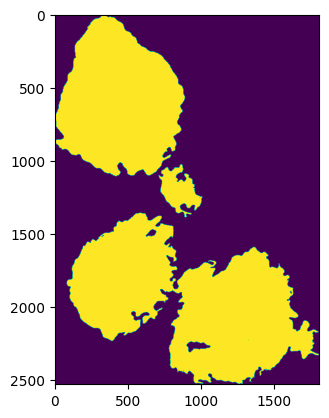

height, width= 309 432
mask_coords [1079, 632, 309, 432]
432 309 1079 1677 632 1568
(1986, 2000)
(2000, 1986)
[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1997 1997 1997 ... 1997 1997 1997]
 [1998 1998 1998 ... 1998 1998 1998]
 [1999 1999 1999 ... 1999 1999 1999]] [[   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 ...
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]]
(202.30473102, 1816.9013501099998)
(224.07169574999998, 1804.5240564399999)
(202.30473102, 1792.14676277)
(223.64489251999998, 1779.7694691)
(202.30473102, 1767.39217543)
(223.64489251999998, 1754.5880785299998)
(202.30473102, 1742.2107848599999)
(223.64489251999998, 1729.83349119)
(202.30473102, 1717.45619752)
(223.64489251999998, 1705.07890385)
(202.30473102, 1692.70161018)
(223.64489251999998, 1680.32431651)
(201.87792779, 1667

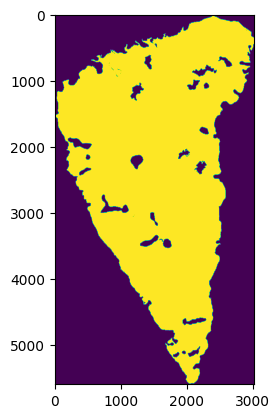

height, width= 515 955
mask_coords [493, 610, 515, 955]
955 515 493 1471 610 1045
(1986, 2000)


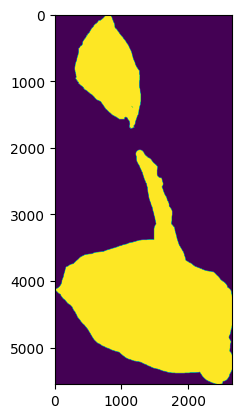

height, width= 453 947
mask_coords [1087, 569, 453, 947]
947 453 1087 1533 569 1053
(1986, 2000)


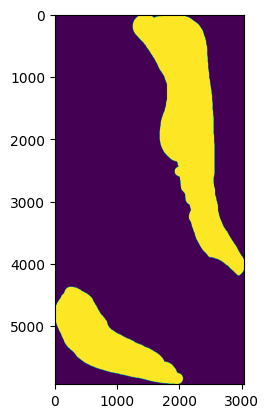

height, width= 519 1012
mask_coords [1023, 542, 519, 1012]
1012 519 1023 1467 542 988
(1986, 2000)
(2000, 1986)
[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1997 1997 1997 ... 1997 1997 1997]
 [1998 1998 1998 ... 1998 1998 1998]
 [1999 1999 1999 ... 1999 1999 1999]] [[   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 ...
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]]
(202.30473102, 1816.9013501099998)
(224.07169574999998, 1804.5240564399999)
(202.30473102, 1792.14676277)
(223.64489251999998, 1779.7694691)
(202.30473102, 1767.39217543)
(223.64489251999998, 1754.5880785299998)
(202.30473102, 1742.2107848599999)
(223.64489251999998, 1729.83349119)
(202.30473102, 1717.45619752)
(223.64489251999998, 1705.07890385)
(202.30473102, 1692.70161018)
(223.64489251999998, 1680.32431651)
(201.87792779, 16

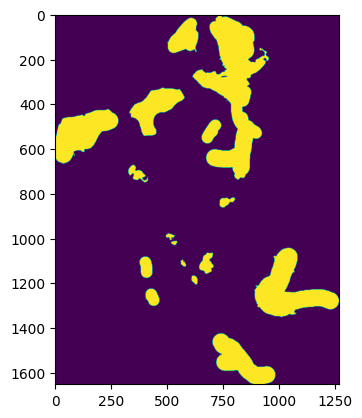

height, width= 216 282
mask_coords [1159, 633, 216, 281]
282 216 1159 1770 633 1719
(1986, 2000)


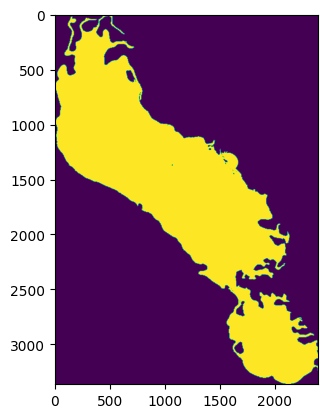

height, width= 409 574
mask_coords [1014, 696, 409, 574]
574 409 1014 1577 696 1426
(1986, 2000)
height, width= 409 574
mask_coords [1106, 587, 301, 452]
574 409 1106 1685 587 1548
(1986, 2000)


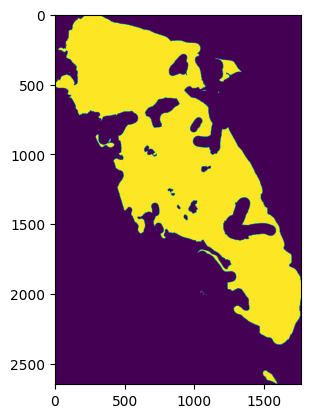

height, width= 301 452
mask_coords [1014, 696, 409, 574]
452 301 1014 1577 696 1426
(1986, 2000)
height, width= 301 452
mask_coords [1106, 587, 301, 452]
452 301 1106 1685 587 1548
(1986, 2000)


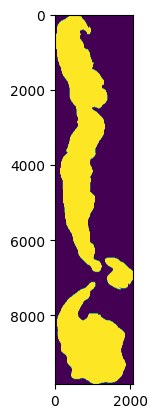

height, width= 354 1678
mask_coords [763, 236, 354, 1678]
1678 354 763 1632 236 322
(1986, 2000)
(2000, 1986)
[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1997 1997 1997 ... 1997 1997 1997]
 [1998 1998 1998 ... 1998 1998 1998]
 [1999 1999 1999 ... 1999 1999 1999]] [[   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 ...
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]
 [   0    1    2 ... 1983 1984 1985]]
(202.30473102, 1816.9013501099998)
(224.07169574999998, 1804.5240564399999)
(202.30473102, 1792.14676277)
(223.64489251999998, 1779.7694691)
(202.30473102, 1767.39217543)
(223.64489251999998, 1754.5880785299998)
(202.30473102, 1742.2107848599999)
(223.64489251999998, 1729.83349119)
(202.30473102, 1717.45619752)
(223.64489251999998, 1705.07890385)
(202.30473102, 1692.70161018)
(223.64489251999998, 1680.32431651)
(201.87792779, 1667

In [82]:

#paths to the tumor and stroma masks 
#print(tumor_path)
for i, space in enumerate(space_folders):
    # go through 10 columns
    path_list = [path0,path1,path2,path3,path4,path5,path6,path7,path8,path9]
    newpaths = []
    # go through all mask types
    for test in path_list:
        if not is_nan(test[i]):
            temp = []
            sample_masks = test[i].split(', ')
            # create new list with list of full paths for masks of each category
            for mask in sample_masks:
                temp.append(os.path.join(mask_dir, mask))
            newpaths.append(temp)
        # mask not provided for this category
        else:
            newpaths.append([])
     # 10
    print(len(newpaths))

    coords = []     # list of lists of coordinates
    mask_images = []    # list of lists of images
    # path is either empty list or list of mask names
    for path in newpaths:
        # path is not an empty list
        if path:
            tempcoords = []
            tempmaskimages = []
            # go through all directories in list of full paths
            for dir in path:
                print(dir)
                tempcoords.append([int(scale*int(j)) for j in dir.split(')')[-2].split(',')[1:]])
                tempmaskimages.append(Image.open(dir))
            coords.append(tempcoords)
            mask_images.append(tempmaskimages)
        else:
            mask_images.append([])
            coords.append([])

    # 10
    print(len(mask_images))
    print(len(coords))

    #Load masks and resize them by 10 and additional scale, multiplying by 4
    padded_images = []  # list of lists of padded images
    for index, m in enumerate(mask_images):
        if m:
            temp = []
            for mimage in m:
                imgplot = plt.imshow(mimage)
                plt.show()
                mimage = mimage.resize((int(mimage.size[0]*scale_factor), int(mimage.size[1]*scale_factor)),Image.Resampling.NEAREST)
                for c in coords[index]:
                    temp.append(padding(mimage, (high_res_x,high_res_y),c))
            padded_images.append(temp)
        else:
            padded_images.append([])
            
            
    # go through all lists of padded images
    for index, pi in enumerate(padded_images):
        if pi:
            for pimg in pi:
                merged_mask = np.zeros_like(pimg)
                #form a mask that labels others as 0, tumor as 1, stroma as 2 , epithelium as 3
                merged_mask = np.where(np.array(pimg)==255,       # where t2 > 5
                                    index,           # put 10
                                    merged_mask)

    points = list(zip(list(tissue_positions['barcode']),[i*tissue_hires_scalef for i in list(tissue_positions['pxl_col_in_fullres'])],  [i* tissue_hires_scalef for i in list(tissue_positions['pxl_row_in_fullres'])]))
    visium_spots_mask, visium_spots_points = sum_pixels_around_points(merged_mask, points,(spot_diameter_fullres/2) *tissue_hires_scalef)

    print(merged_mask, merged_mask.shape, np.unique(merged_mask))
    # Segment image with SLIC - Simple Linear Iterative Clustering
    # seg = segmentation.slic(tiger, n_segments=30, compactness=40.0, enforce_connectivity=True, sigma=3)
        
    # Generate automatic colouring from classification labels
    
    cv2.imwrite(os.path.join(visium_path,'tissue_category_mask.png'), cv2.cvtColor((color.label2rgb(merged_mask, myimg)* 255).astype('uint8'), cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(visium_path, 'visium_spots_mask.png'), cv2.cvtColor((color.label2rgb(visium_spots_mask, myimg)* 255).astype('uint8'), cv2.COLOR_RGB2BGR))
    


In [67]:
print(dir)

/Users/serenapei/ASTAR/Y90HCC/QuPath_masks/


In [ ]:
#get all tissue positions in full res
print(visium_path)
tissue_positions = pd.read_csv(
    list(visium_path.rglob('tissue_positions.csv'))[0],
            index_col=None)
print(tissue_positions)

/Users/serenapei/ASTAR/Y90HCC/NCC016Post_NCC011Post/outs/spatial
                 barcode  in_tissue  array_row  array_col  pxl_row_in_fullres  \
0     ACGCCTGACACGCGCT-1          0          0          0                4257   
1     TACCGATCCAACACTT-1          0          1          1                4228   
2     ATTAAAGCGGACGAGC-1          0          0          2                4199   
3     GATAAGGGACGATTAG-1          0          1          3                4170   
4     GTGCAAATCACCAATA-1          0          0          4                4141   
...                  ...        ...        ...        ...                 ...   
4987  GAACGTTTGTATCCAC-1          0         77        123                 673   
4988  ATTGAATTCCCTGTAG-1          0         76        124                 644   
4989  TACCTCACCAATTGTA-1          0         77        125                 615   
4990  AGTCGAATTAGCGTAA-1          0         76        126                 586   
4991  TTGAAGTGCATCTACA-1          0         

In [ ]:
# #finding achor points based on fname
# # the anchor points (indicated in the mask filename is based on the full res HE, so 'scale' is used instead of 'scale_factor')
    

# stroma_coords = [int(scale*int(i)) for i in stroma_fpath.split(')')[-2].split(',')[1:]]
# tumor_coords = [int(scale*int(i)) for i in tumor_fpath.split(')')[-2].split(',')[1:]]
# if is_nan(epithelial_path[i]):
#     print("Epithelial mask is absent")
# else:
#     epithelial_coords = [int(scale*int(i)) for i in epithelial_fpath.split(')')[-2].split(',')[1:]]
#     print(epithelial_fpath)
#     print(epithelial_fpath.split(')'))
#     print(epithelial_fpath.split(')')[-2])
#     print(epithelial_fpath.split(')')[-2].split(',')[1:])

# print('stroma_coords=',stroma_coords)
# print('tumor_coords=',tumor_coords)
# print('\n')
# print(stroma_fpath)
# print(stroma_fpath.split(')'))
# print(stroma_fpath.split(')')[-2])
# print(stroma_fpath.split(')')[-2].split(',')[1:])
# print('\n')

# print(tumor_fpath)
# print(tumor_fpath.split(')'))
# print(tumor_fpath.split(')')[-2])
# print(tumor_fpath.split(')')[-2].split(',')[1:])

Epithelial mask is absent
stroma_coords= [0, 100, 1983, 1898]
tumor_coords= [58, 23, 1918, 1935]


/Users/serenapei/ASTAR/Y90HCC/QuPath_masks/V11N0-086_H&E_Whole Slide.czi - Scene #4_Stroma_(4.00,0,2352,46480,44480)-mask.png
['/Users/serenapei/ASTAR/Y90HCC/QuPath_masks/V11N0-086_H&E_Whole Slide.czi - Scene #4_Stroma_(4.00,0,2352,46480,44480', '-mask.png']
/Users/serenapei/ASTAR/Y90HCC/QuPath_masks/V11N0-086_H&E_Whole Slide.czi - Scene #4_Stroma_(4.00,0,2352,46480,44480
['0', '2352', '46480', '44480']


/Users/serenapei/ASTAR/Y90HCC/QuPath_masks/V11N0-086_H&E_Whole Slide.czi - Scene #4_Tumor_(4.00,1360,560,44960,45352)-mask.png
['/Users/serenapei/ASTAR/Y90HCC/QuPath_masks/V11N0-086_H&E_Whole Slide.czi - Scene #4_Tumor_(4.00,1360,560,44960,45352', '-mask.png']
/Users/serenapei/ASTAR/Y90HCC/QuPath_masks/V11N0-086_H&E_Whole Slide.czi - Scene #4_Tumor_(4.00,1360,560,44960,45352
['1360', '560', '44960', '45352']


In [ ]:
# #Load masks and resize them by 10 and additional scale, multiplying by 4
# stroma_mask = Image.open(stroma_fpath)
# tumor_mask = Image.open(tumor_fpath)
# if is_nan(epithelial_path[i]):
#     print("Epithelial mask is absent")
# else:
#     epithelial_mask = Image.open(epithelial_fpath)
# imgplot = plt.imshow(tumor_mask)
# plt.show()
# print('stroma_mask size: ', stroma_mask.size)
# print('tumor_mask size: ', tumor_mask.size)

# stroma_mask = stroma_mask.resize((int(stroma_mask.size[0]*scale_factor), int(stroma_mask.size[1]*scale_factor)),Image.Resampling.NEAREST)
    
# tumor_mask = tumor_mask.resize((int(tumor_mask.size[0]*scale_factor), int(tumor_mask.size[1]*scale_factor)), Image.Resampling.NEAREST ) 
# if is_nan(epithelial_path[i]):
#     print("Epithelial mask is absent")
# else:
#     epithelial_mask = epithelial_mask.resize((int(epithelial_mask.size[0]*scale_factor), int(epithelial_mask.size[1]*scale_factor)), Image.Resampling.NEAREST ) 
#     imgplot = plt.imshow(epithelial_mask)
#     plt.show()
# print('\n')
# print('stroma_mask size: ', stroma_mask.size)
# print('tumor_mask size: ', tumor_mask.size)
# imgplot = plt.imshow(stroma_mask)
# plt.show()

In [ ]:
# print(high_res_x,high_res_y)
# stroma_mask = padding(stroma_mask, (high_res_x,high_res_y), stroma_coords)
# tumor_mask = padding(tumor_mask, (high_res_x,high_res_y), tumor_coords)
    
# if is_nan(epithelial_path[i]):
#     print("Epithelial mask is absent")
# else:
#     epithelial_mask = padding(epithelial_mask, (high_res_x,high_res_y), epithelial_coords)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#img = mpimg.imread('path_to_your_image.png')
imgplot = plt.imshow(stroma_mask)
plt.show()

imgplot = plt.imshow(img)
plt.show()

In [ ]:
# merged_mask = np.zeros_like(stroma_mask)
# #form a mask that labels others as 0, tumor as 1, stroma as 2 , epithelium as 3
# merged_mask = np.where(np.array(stroma_mask)==255,       # where t2 > 5
#                         2,           # put 10
#                         merged_mask)
# merged_mask = np.where(np.array(tumor_mask) ==255,       # where t2 > 5
#                         1,           # put 10
#                         merged_mask)  

# if is_nan(epithelial_path[i]):
#     print("Epithelial mask is absent")
# else:
#     merged_mask = np.where(np.array(epithelial_mask) ==255,       # where t2 > 5
#                     3,           # put 10
#                     merged_mask)    
# print(merged_mask.shape, "shape")
# print(stroma_mask.size)

def sum_pixels_around_points(image, points, radius):
    #mapping = {0:3,1:4,2:5}
    #mapping = {0:3, 1:1, 2:2}
    mapping = {0:4, 1:1, 2:2, 3:3}
    height, width = image.shape
    print(image.shape)
    y_coords, x_coords = np.indices((height, width))
    print(y_coords, x_coords)
    total_sum = []
    image_masked = np.zeros_like(image)
    #for point in points:
    #    x, y = point
    #   mask = ((x_coords - x) ** 2 + (y_coords - y) ** 2) <= radius ** 2
    #    counts = np.unique(image[mask],return_counts = True)
    #    conversion = counts[0][np.argmax(counts[1])]
    #    image_masked[mask] = int(mapping[conversion])
    for i, point in enumerate(points):
        x, y = point[1], point[2]
        mask = ((x_coords - x) ** 2 + (y_coords - y) ** 2) <= radius ** 2
        counts = np.unique(image[mask],return_counts = True)
        #0 is background, 1 is tumor, 2 is stroma 
        
        # Mask values other than 0
        values_mask = counts[0] != 0
        # Check if any values are masked (i.e., 1, 2, or 3 exists)
        if np.any(values_mask):
            # Filter the counts based on the mask
            filtered_counts = counts[1][values_mask]
            
            # Get the index of the maximum count in the filtered counts
            max_index_filtered = np.argmax(filtered_counts)
            
            # Use this index to get the corresponding value from the masked values in counts[0]
            conversion = counts[0][values_mask][max_index_filtered]
        else:
            # If no 1, 2, or 3 values are detected, default to the most frequent value
            conversion = counts[0][np.argmax(counts[1])]

        
        # try:
            # conversion = counts[0][np.argmax(counts[1])]
        # except:
            # return(None, None) 
        image_masked[mask] = int(mapping[conversion])
        points[i] = point+ (conversion,)
    return image_masked, points
    #return image_masked

In [ ]:
points = list(zip(list(tissue_positions['barcode']),[i*tissue_hires_scalef for i in list(tissue_positions['pxl_col_in_fullres'])],  [i* tissue_hires_scalef for i in list(tissue_positions['pxl_row_in_fullres'])]))
visium_spots_mask, visium_spots_points = sum_pixels_around_points(merged_mask, points,(spot_diameter_fullres/2) *tissue_hires_scalef)


In [ ]:
#create the masks, fails for one case because point to check is outside of mask size, to check again
if visium_spots_mask is None:
# this step is necessary because V11A07-085_Frame1C is out of the frame. 
    with open(visium_spots_log, 'a') as f:
        f.write('failed: ' + space+ '\n')
    print(space)
else:
    with open(visium_spots_log, 'a') as f:
        f.write('success: ' + space+ '\n')
    print(space)
    print('success!')    
    visium_spots_df = pd.DataFrame(visium_spots_points, columns = ['barcode', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'Class (0: None, 1: Tumor, 2: Stroma)'])
    visium_spots_df.to_csv(visium_spots_csv_save)
    
    print(visium_spots_df)

In [ ]:
print(merged_mask, merged_mask.shape, np.unique(merged_mask))
# Segment image with SLIC - Simple Linear Iterative Clustering
# seg = segmentation.slic(tiger, n_segments=30, compactness=40.0, enforce_connectivity=True, sigma=3)
    
# Generate automatic colouring from classification labels
    
cv2.imwrite(os.path.join(visium_path,'tissue_category_mask.png'), cv2.cvtColor((color.label2rgb(merged_mask, img)* 255).astype('uint8'), cv2.COLOR_RGB2BGR))
    
cv2.imwrite(os.path.join(visium_path, 'visium_spots_mask.png'), cv2.cvtColor((color.label2rgb(visium_spots_mask, img)* 255).astype('uint8'), cv2.COLOR_RGB2BGR))
print(stroma_mask.size , tumor_mask.size)

In [ ]:
print(visium_path)